This morning, I saw a cool looking tweet on sci-twitter. Since it's about waves and it looks very nice, I want to try to reproduce it and share the results.

That's the tweet:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/PhysicsFactlet?src=hash&amp;ref_src=twsrc%5Etfw">#PhysicsFactlet</a> (220)<br>Wavefront shaping: If you can control the relative phase of a number of point emitters, you can control the shape of your propagating wave.<br>(Shown: plane wave, focus, and Airy beam) <a href="https://t.co/5QN5e1xZn2">pic.twitter.com/5QN5e1xZn2</a></p>&mdash; Jacopo Bertolotti (@j_bertolotti) <a href="https://twitter.com/j_bertolotti/status/1252635852867547137?ref_src=twsrc%5Etfw">April 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

The way I understand what's going on, we need the following building blocks to get to make an animation that looks like the one in the tweet:

- single cylindrical wave source on a grid
- line of cylindrical wave sources on a grid
- take into account phase delays to allow for focusing and beam deviation

Let's get started.

# Cylindrical waves on a grid

In its simplest form, we can use a Green's function approach and just evaluate the solution of a single line source. Based on the analytical solution for the 3D Helmholtz equation (as can be read in [this reference](https://users.flatironinstitute.org/~ahb/notes/waveequation.pdf)), we can write

$$
f(r) = \frac{e^{ikr}}{4πr} 
$$

We can write some straightforward code to evaluate this on a grid, that I choose to be the same than in the tweet.

In [1]:
import numpy as np

wavelength = 1.
n_lambda = 20.
n_points = 401
dx = n_lambda * wavelength / (n_points - 1)
k = 2 * np.pi / wavelength
print(f"number of points per wavelenght: {wavelength/dx}")
x = np.linspace(-n_lambda//2 * wavelength, n_lambda//2 * wavelength, num=n_points)
y = np.linspace(0, n_lambda * wavelength, num=n_points)
X, Y = np.meshgrid(x, y)

number of points per wavelenght: 20.0


Now let's write a function that allows us to compute the field amplitude.

In [2]:
def compute_amplitude_from_source_point(source_location, X, Y, k):
    x0, y0 = source_location
    R = np.sqrt((X - x0)**2 + (Y - y0)**2)
    amp = np.exp(1j * k * R) 
    amp[np.isinf(amp)] = 0.
    return np.real(amp)

amp = compute_amplitude_from_source_point((0., 0.), X, Y, k)

And let's display it.

:Image   [x,y]   (z)
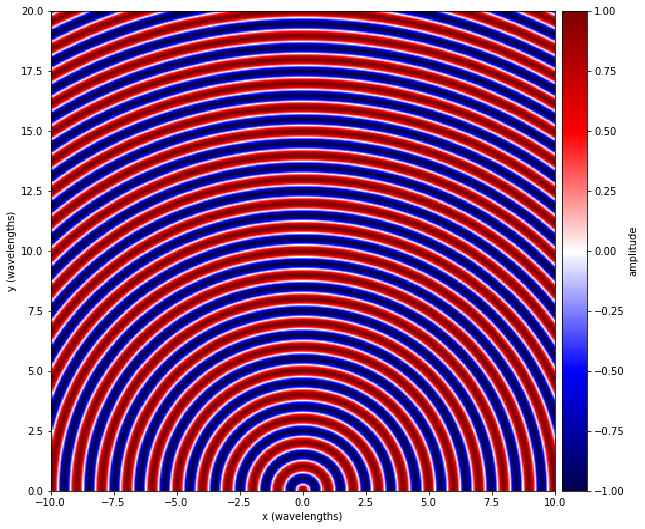

In [3]:
import holoviews as hv
hv.extension('matplotlib', logo=False)
FIG_OPTS = hv.opts(aspect=1.05, fig_inches=10)

def plot(amp):
    return hv.Image(amp[::-1], bounds=[-10, 0, 10, 20]).opts(colorbar=True, cmap='seismic').redim.label(x='x (wavelengths)', y='y (wavelengths)', z='amplitude').opts(FIG_OPTS)

plot(amp)

# A line of cylindrical sources 

To compute the field produced by a set of sources on a grid, we can just add up the resulting fields. Let's write some helper functions to do that.

In [4]:
def make_symmetric_point_source(n_one_side, dx):
    pos = np.arange(-n_one_side, n_one_side + 1) * dx
    return np.c_[pos, np.zeros_like(pos)]

line_source = make_symmetric_point_source(5, wavelength / 2.)
line_source

array([[-2.5,  0. ],
       [-2. ,  0. ],
       [-1.5,  0. ],
       [-1. ,  0. ],
       [-0.5,  0. ],
       [ 0. ,  0. ],
       [ 0.5,  0. ],
       [ 1. ,  0. ],
       [ 1.5,  0. ],
       [ 2. ,  0. ],
       [ 2.5,  0. ]])

In [5]:
def compute_amplitude_from_several_points(source_locations, X, Y, k):
    field = np.zeros_like(X)
    for source_location in source_locations:
        field += compute_amplitude_from_source_point(source_location, X, Y, k)
    return field

field = compute_amplitude_from_several_points(line_source, X, Y, k)

:Overlay
   .Image.I  :Image   [x,y]   (z)
   .Points.I :Points   [x,y]
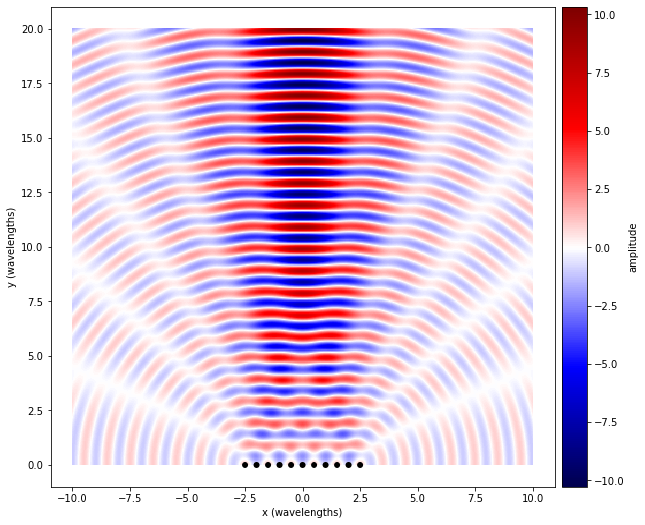

In [6]:
def plot_field(field, line_source):
    return (plot(field).opts(FIG_OPTS) * hv.Points(line_source).opts(color='black', padding=0.05)).opts(FIG_OPTS)

plot_field(field, line_source)

Let's see what this looks like with several source points.

:HoloMap   [number of points]
   :Overlay
      .Image.I  :Image   [x,y]   (z)
      .Points.I :Points   [x,y]
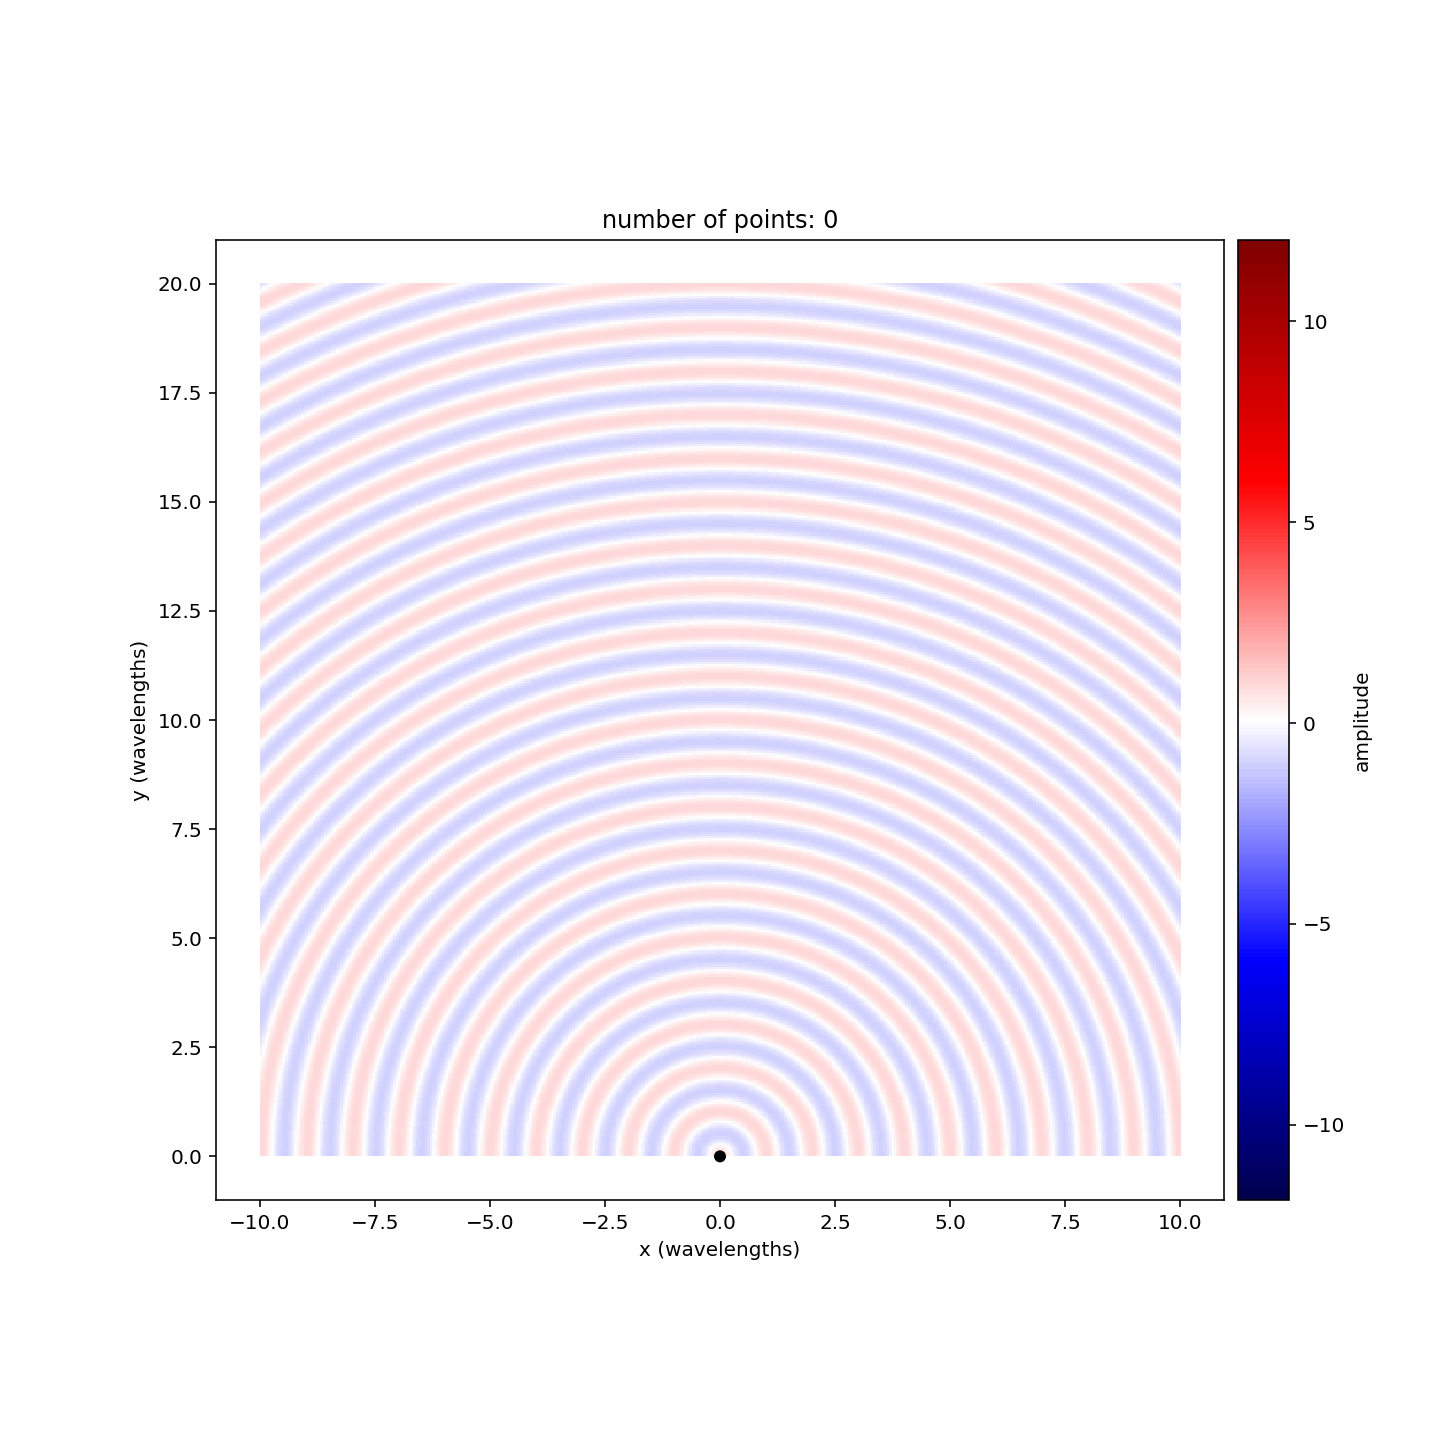
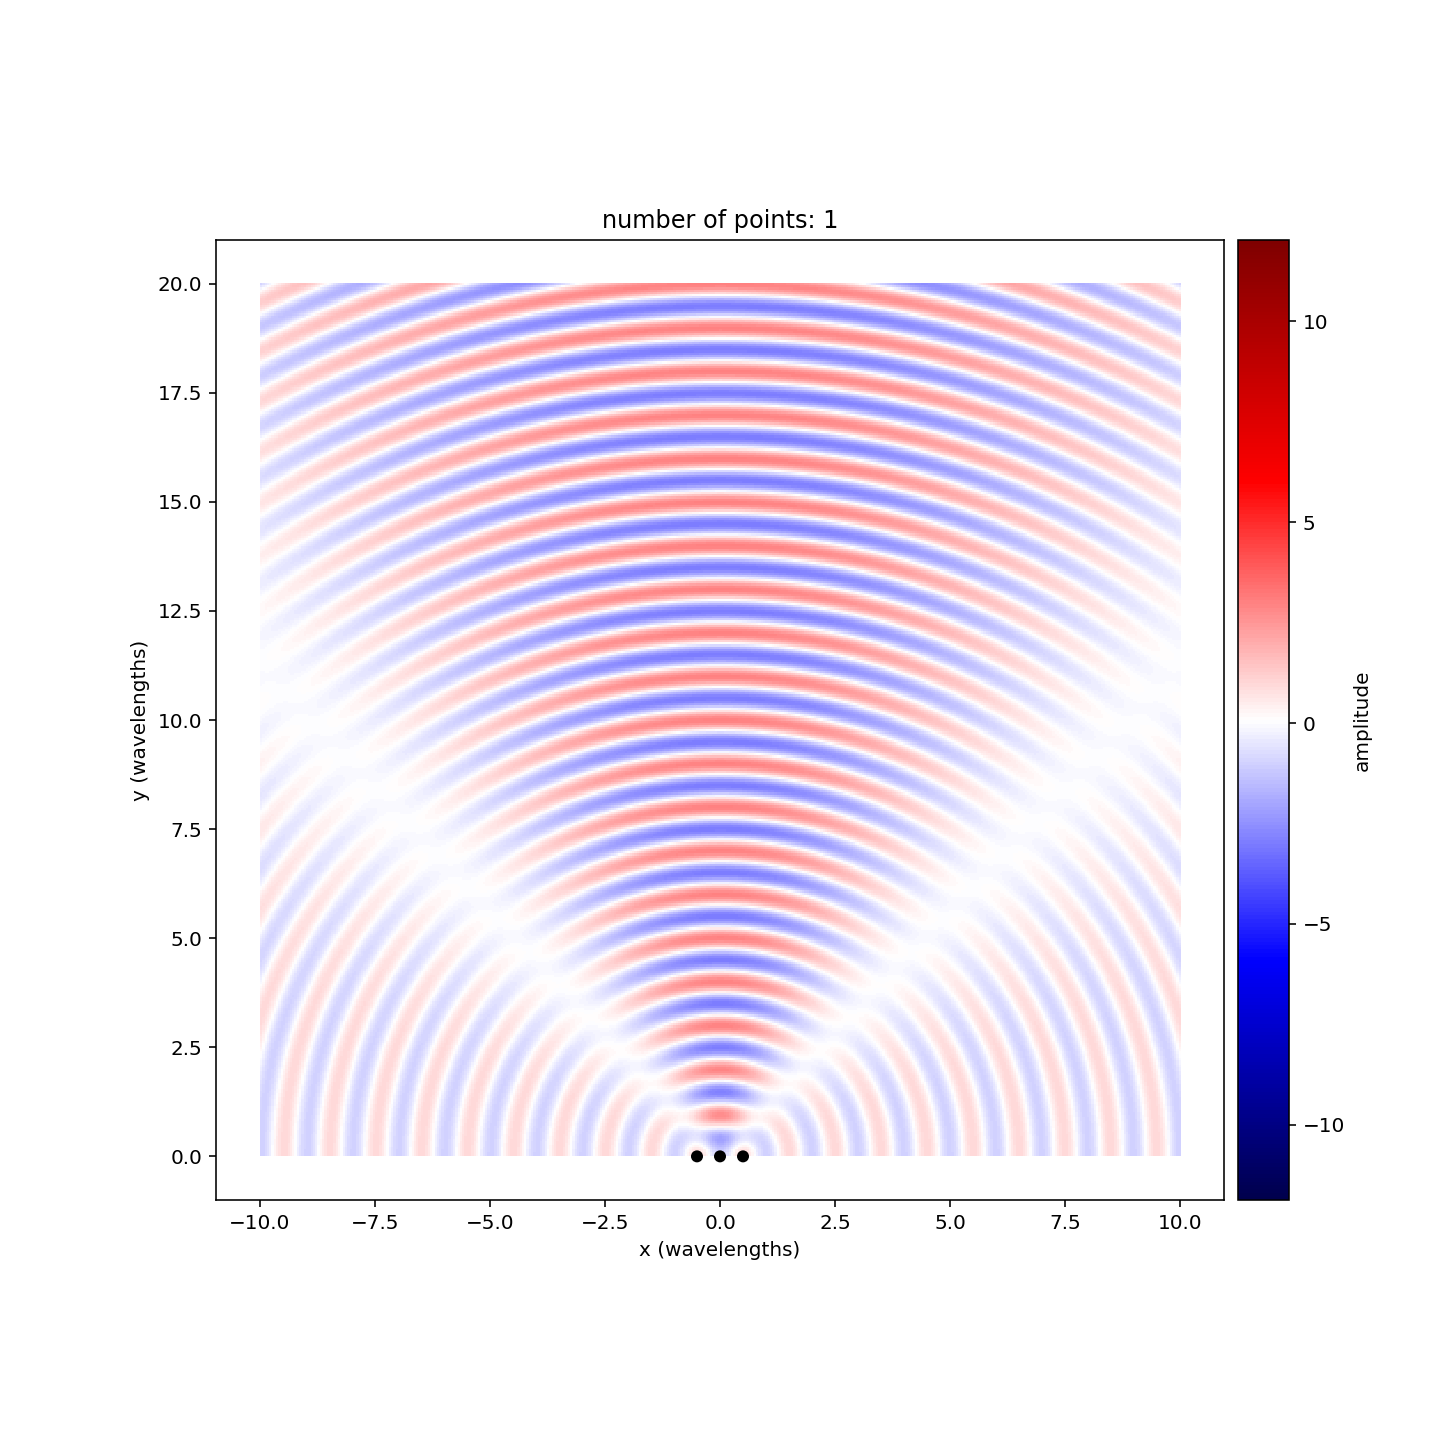
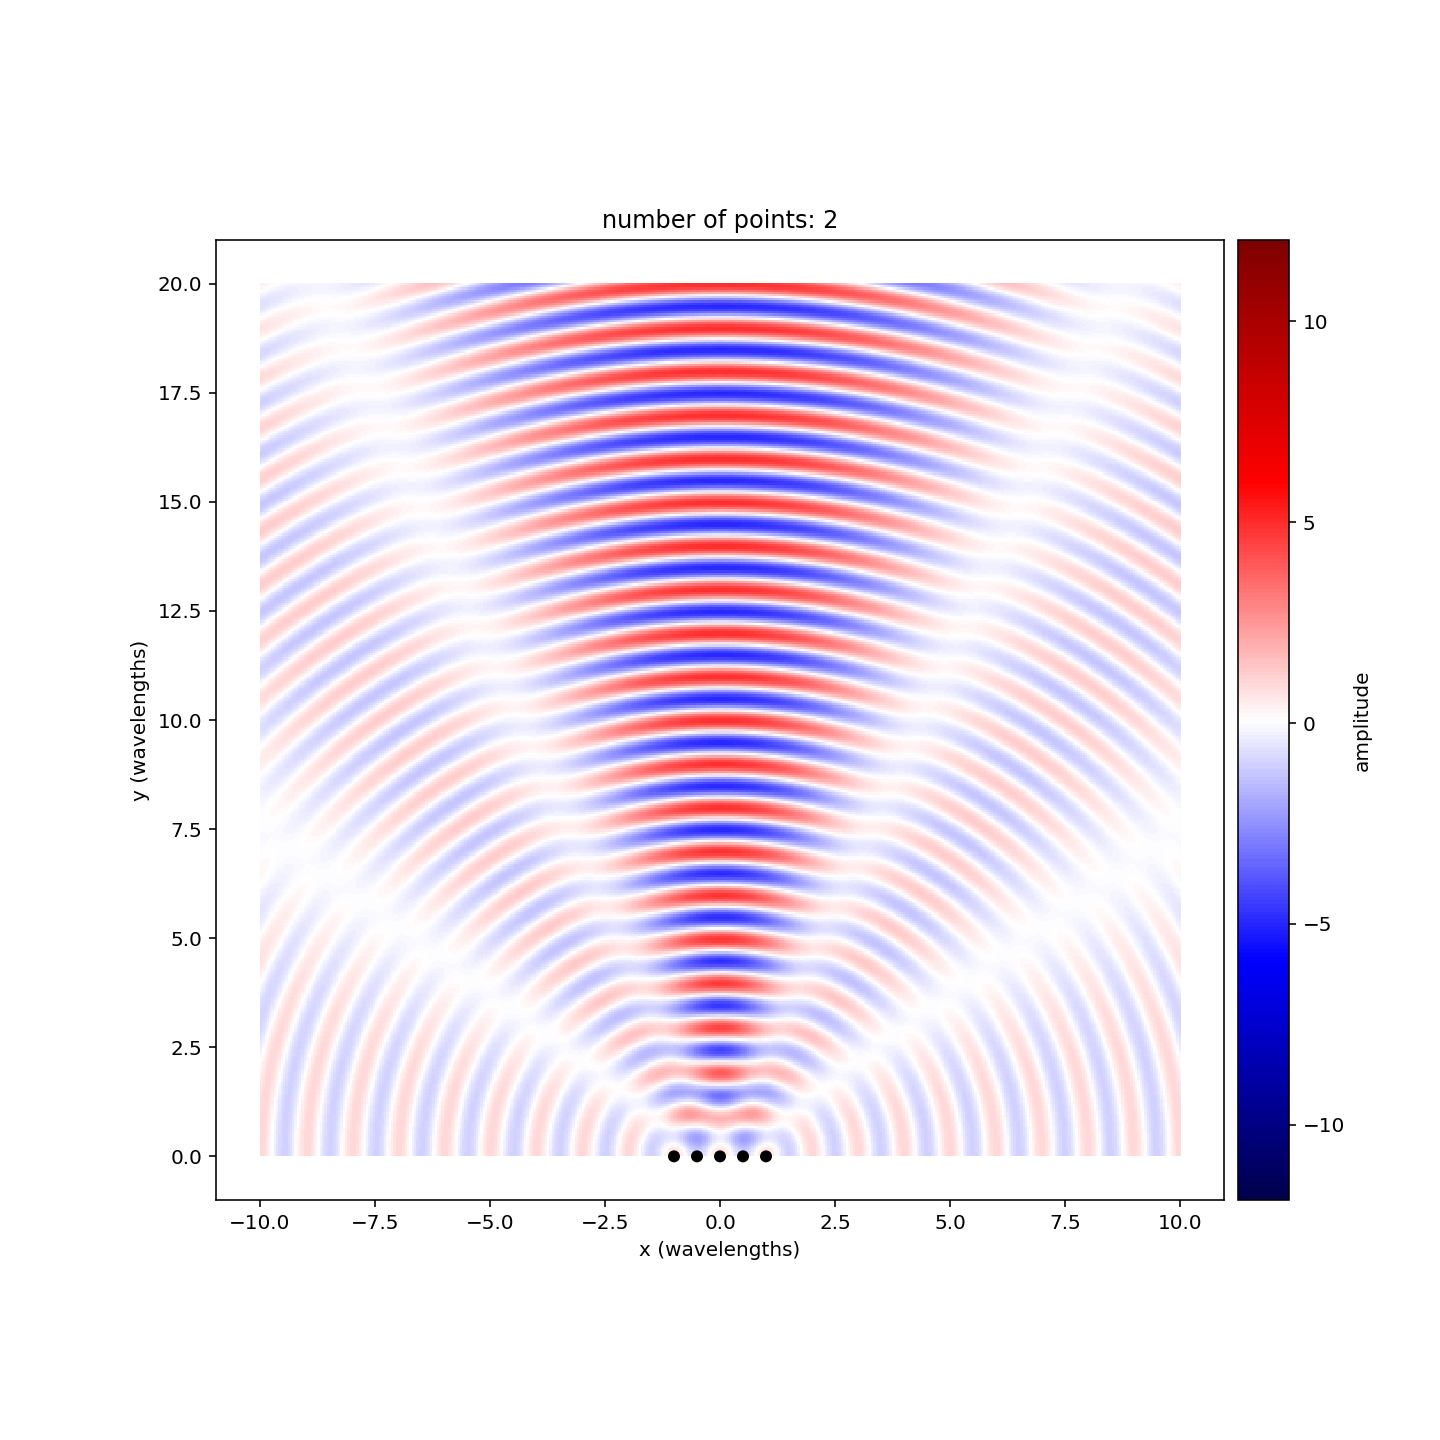
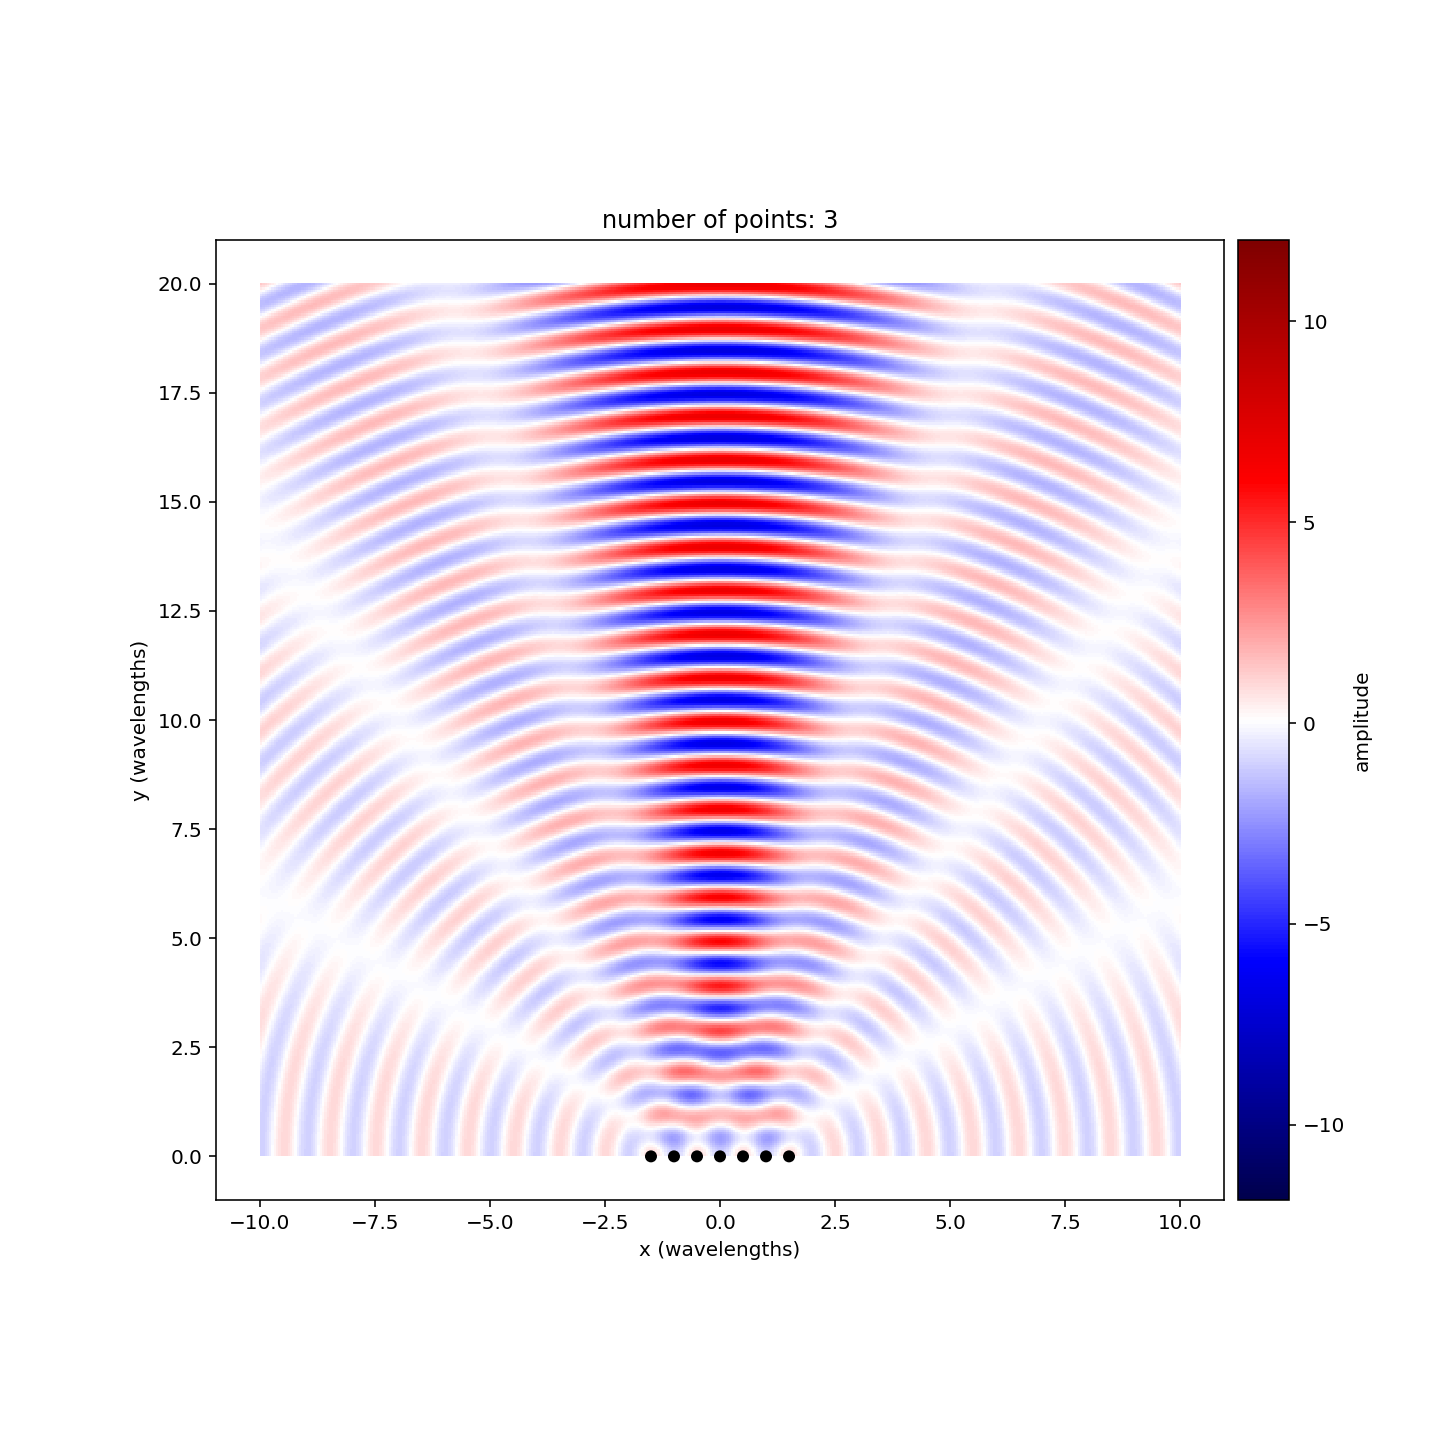
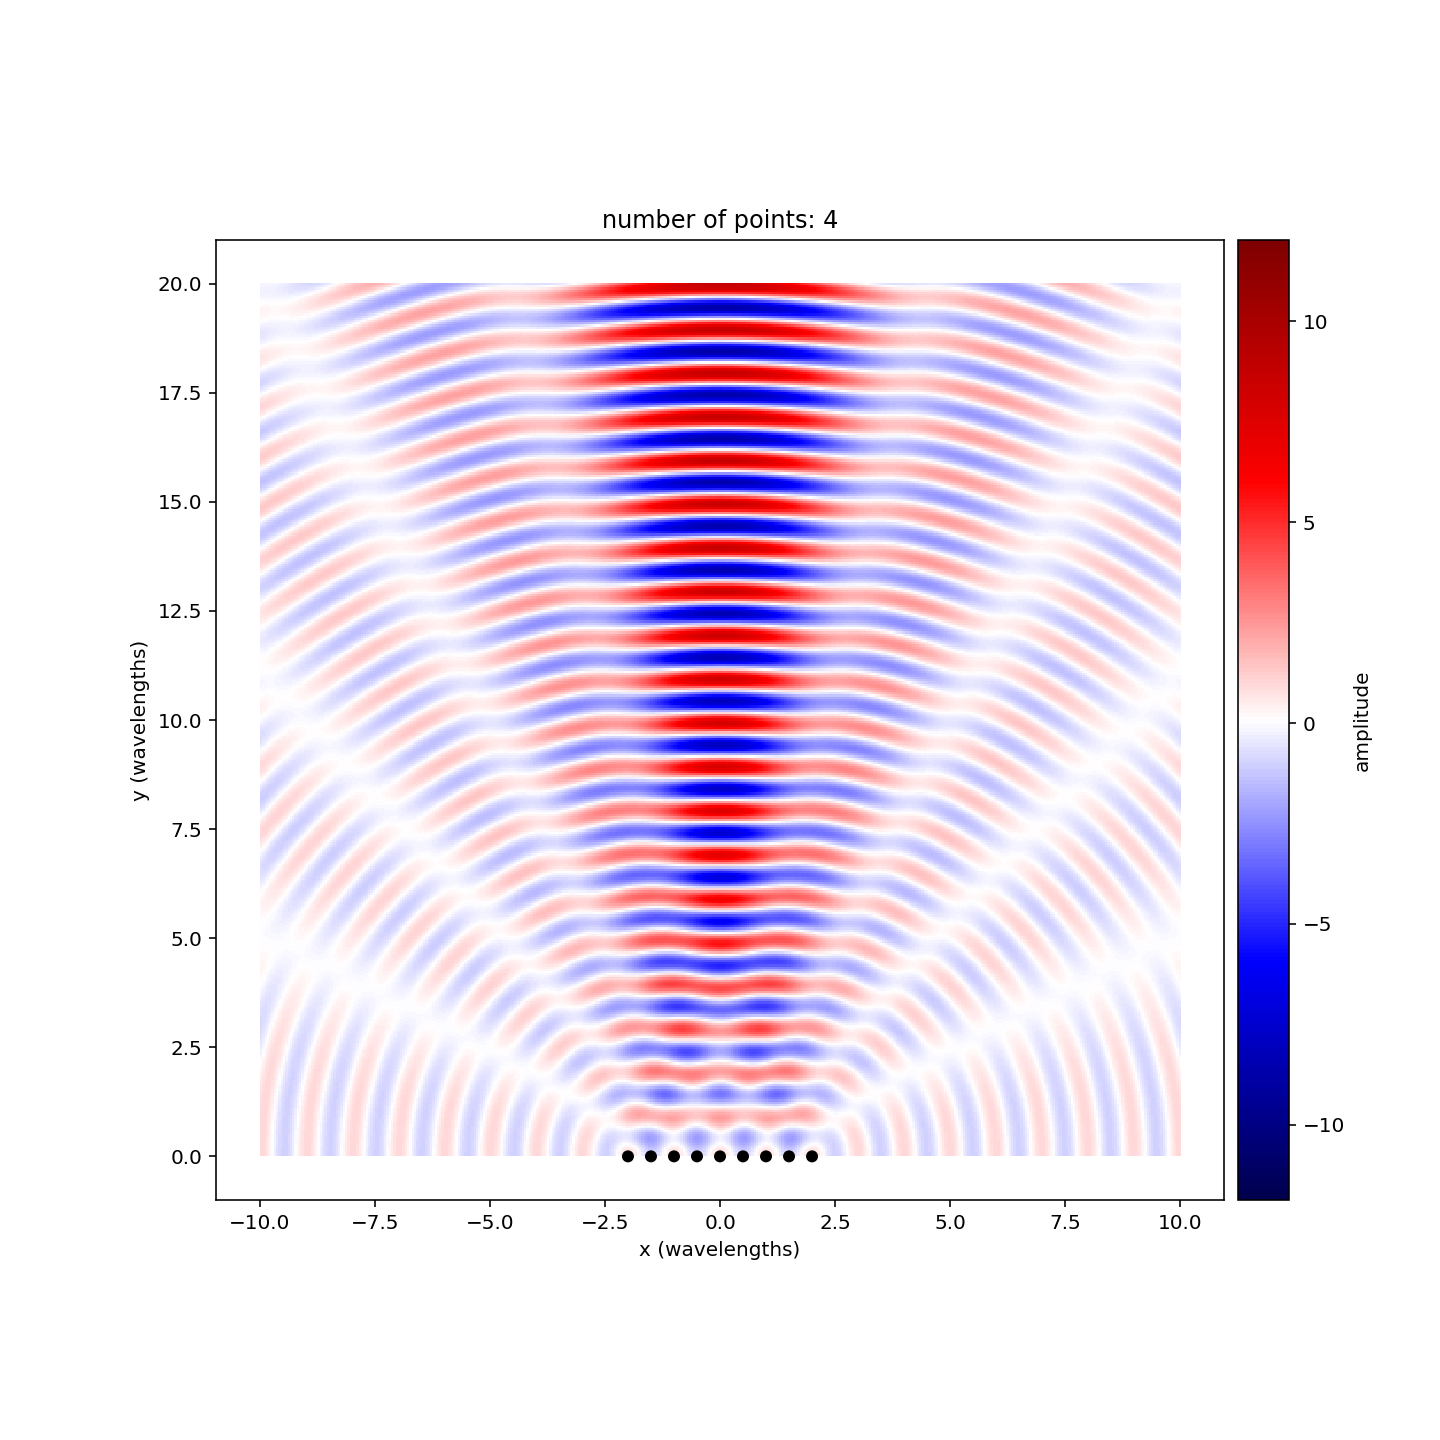
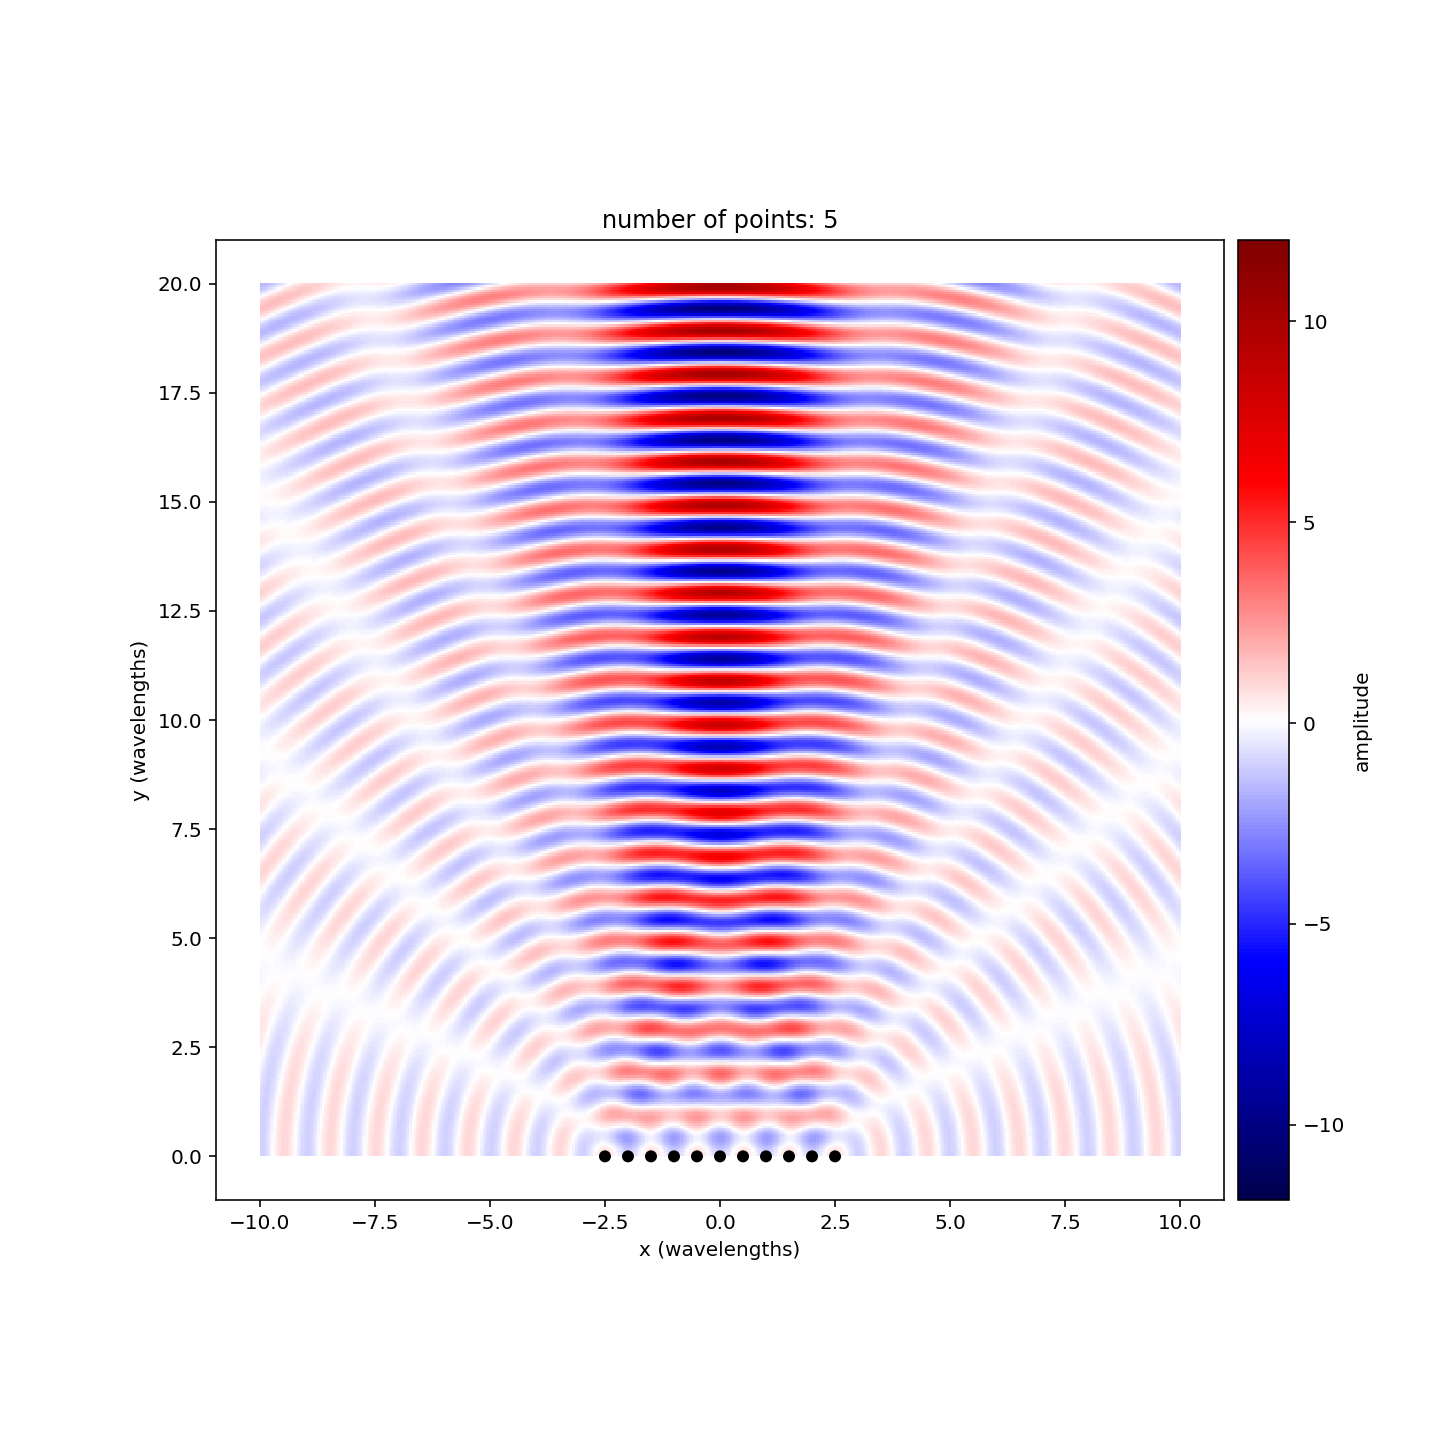
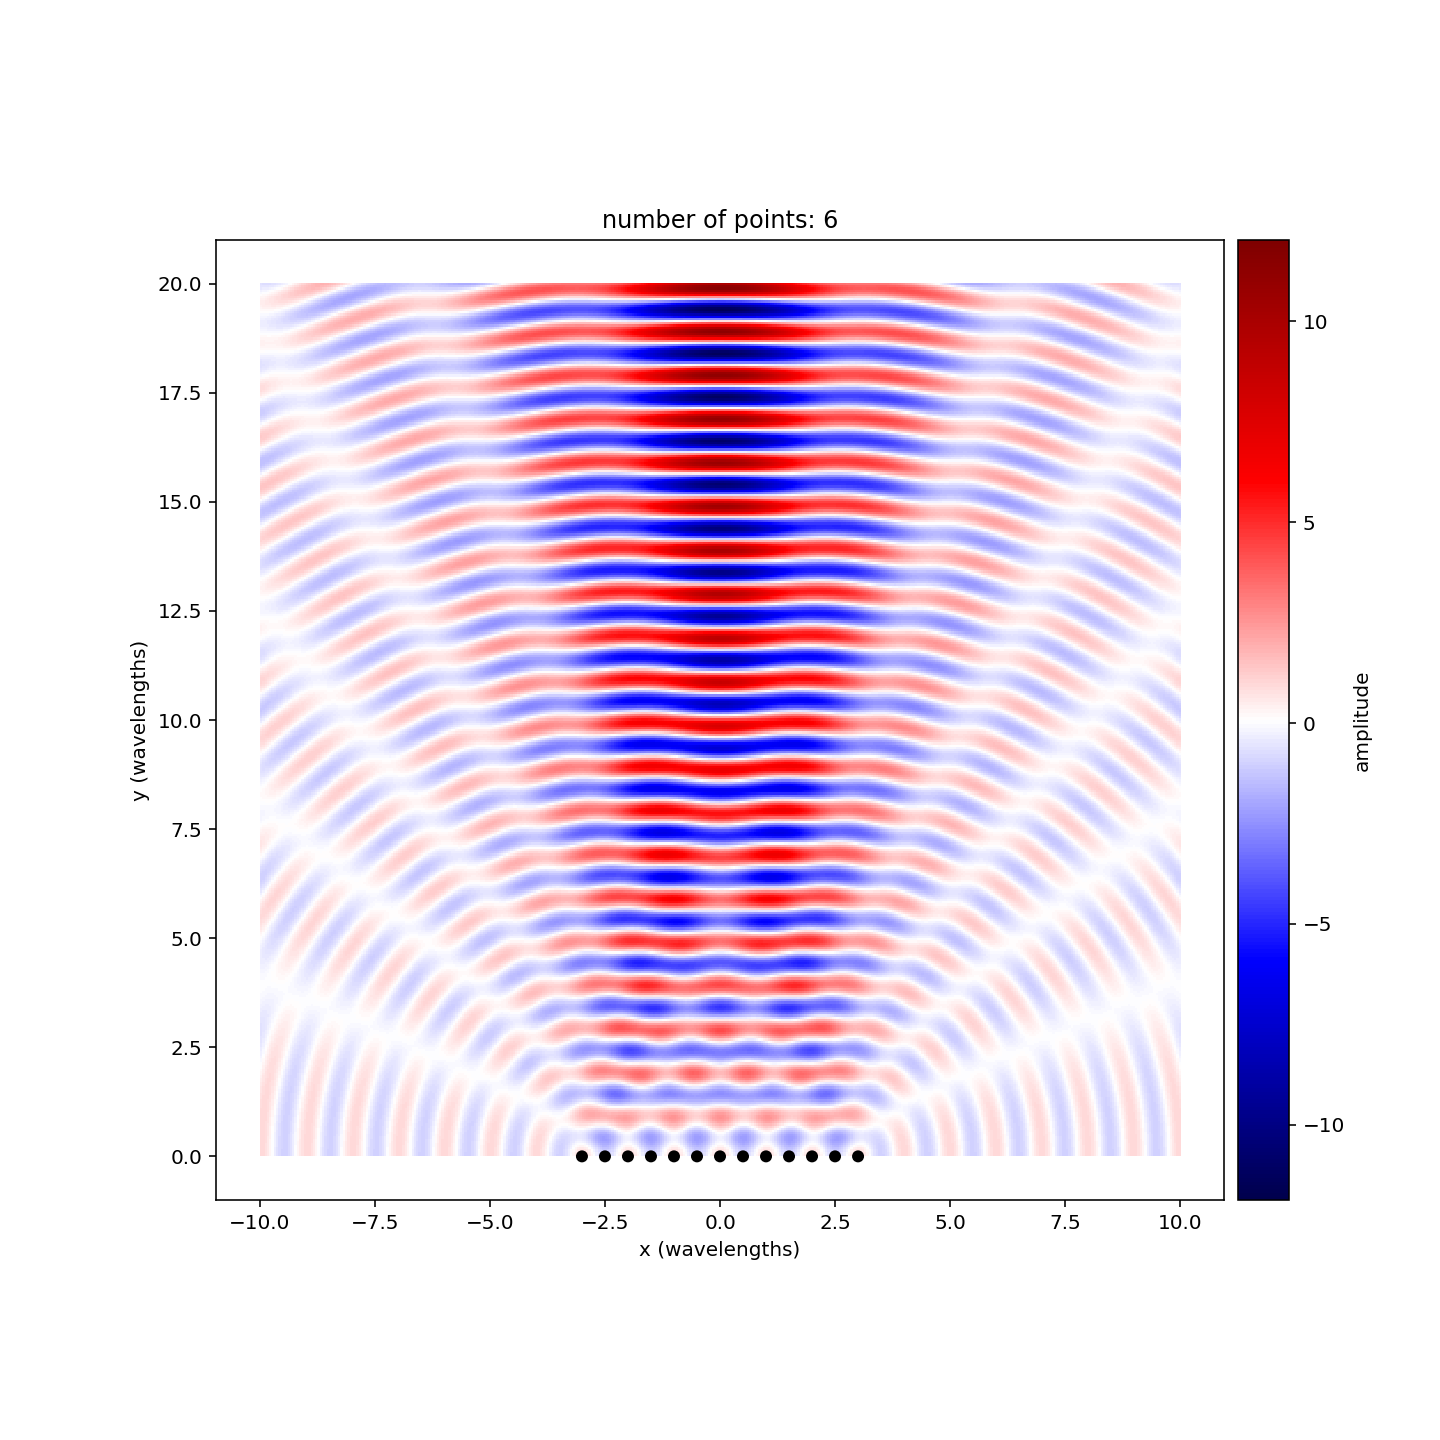
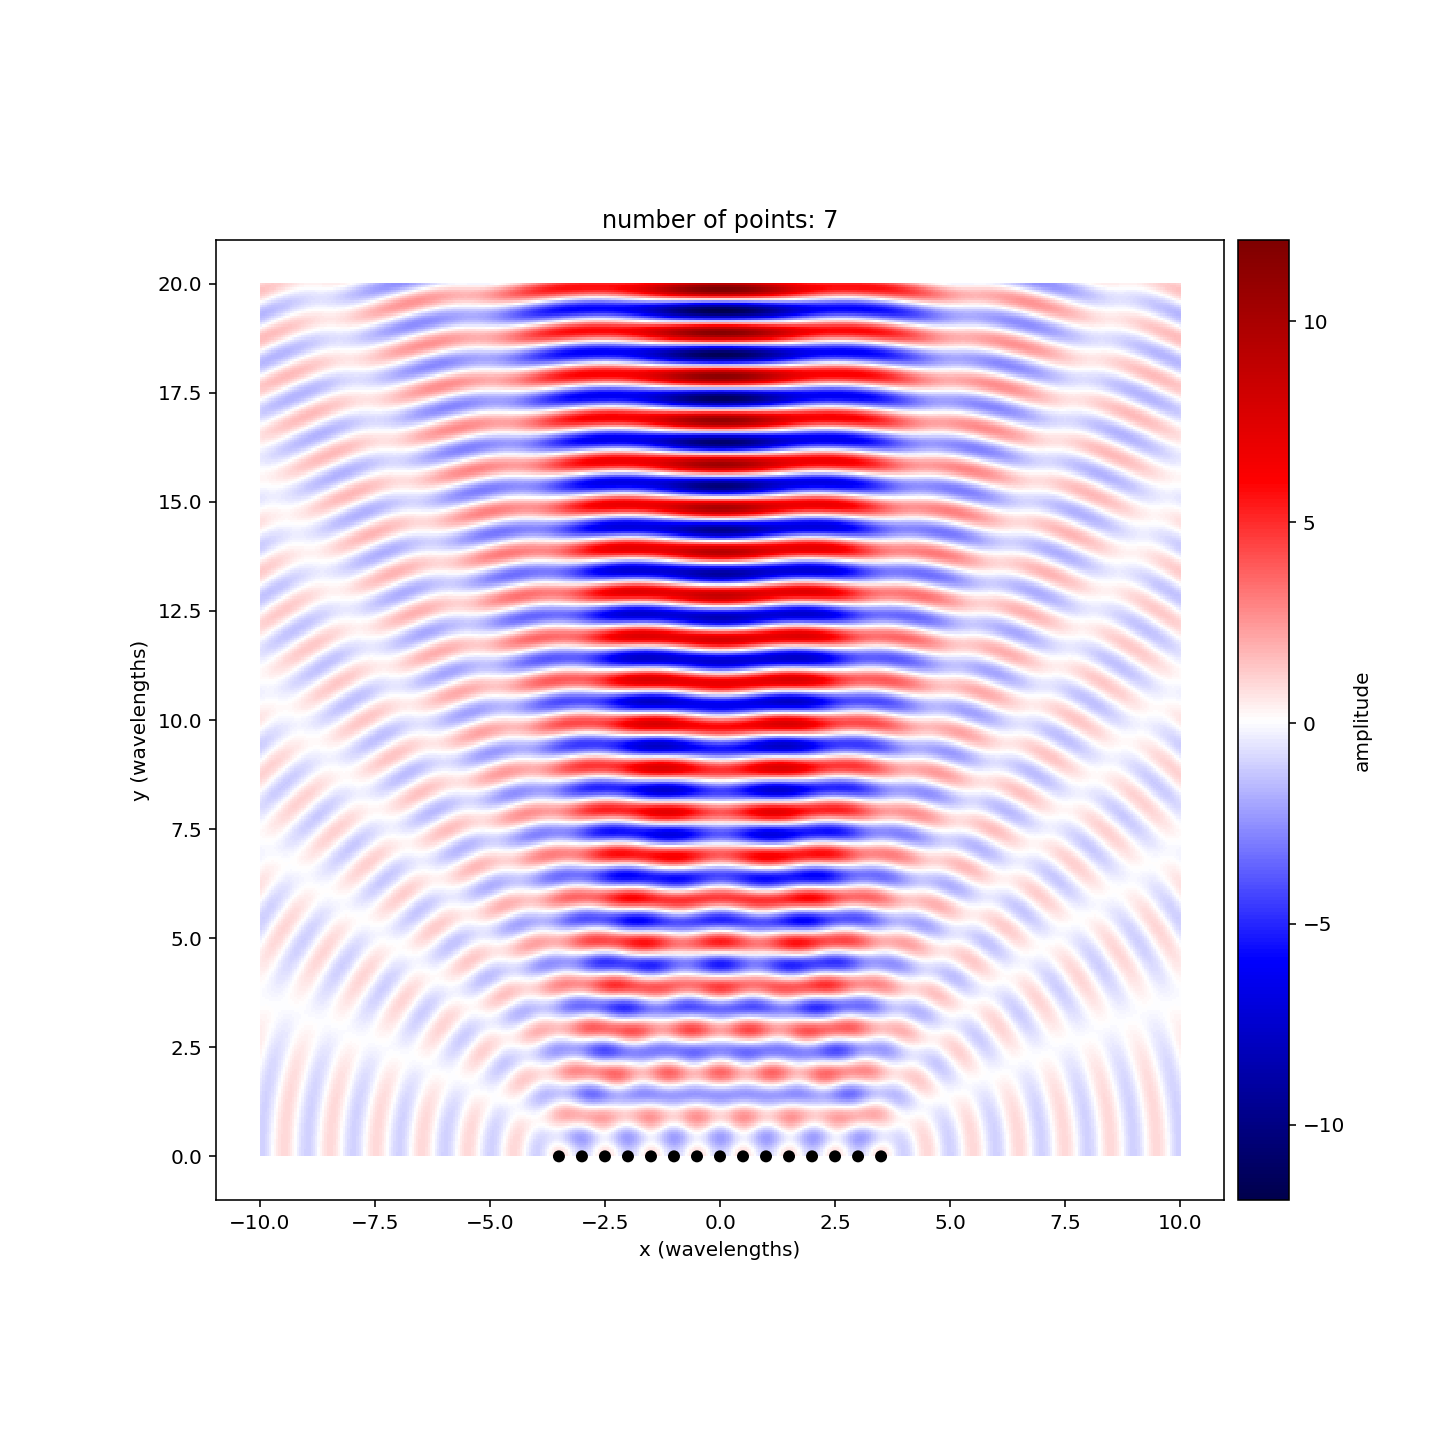
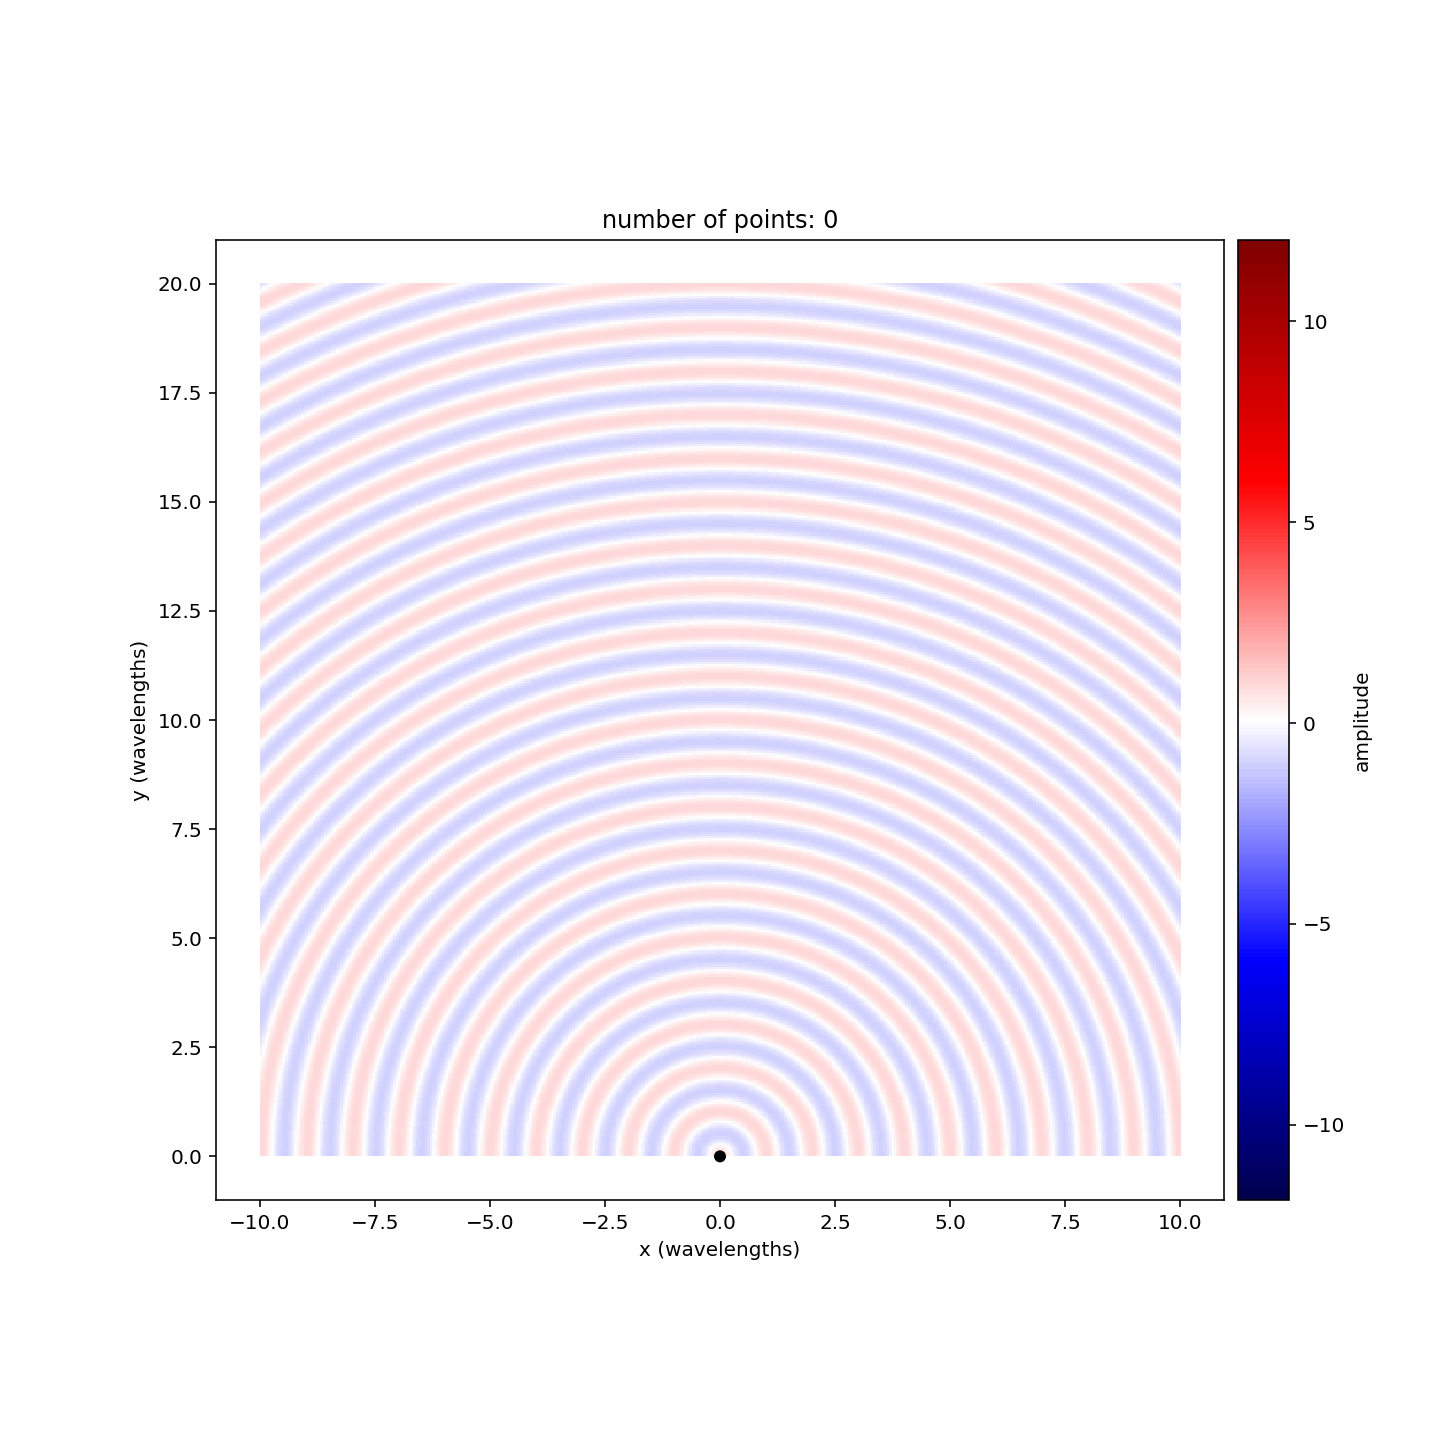

In [7]:
viz_data = {}
for n_points in [0, 1, 2, 3, 4, 5, 6, 7]:
    line_source = make_symmetric_point_source(n_points, wavelength / 2.)
    field = compute_amplitude_from_several_points(line_source, X, Y, k)
    viz_data[n_points] = plot_field(field, line_source)
    
hv.HoloMap(viz_data, kdims='number of points')

# Adding delays for focusing

If we want to focus the wave, we can compute some delays that can easily be put into the field. We basically just need to delay the waves so that they reach the focal point all at the same time.

In [8]:
def compute_amplitude_from_source_point_with_focus(source_location, X, Y, k, focus_location):
    x0, y0 = source_location
    xF, yF = focus_location
    r = np.sqrt((x0 - xF)**2 + (y0 - yF)**2)
    R = np.sqrt((X - x0)**2 + (Y - y0)**2)
    amp = np.exp(1j * k * (R - r)) 
    amp[np.isinf(amp)] = 0.
    return np.real(amp)

amp = compute_amplitude_from_source_point_with_focus((0., 0.), X, Y, k, focus_location=(0, 20 * wavelength))

def compute_amplitude_from_several_points_with_focus(source_locations, X, Y, k, focus_location):
    field = np.zeros_like(X)
    for source_location in source_locations:
        field += compute_amplitude_from_source_point_with_focus(source_location, X, Y, k, focus_location)
    return field

Let's see how this goes if we move the focus along a line.

:HoloMap   [focus location]
   :Overlay
      .Image.I  :Image   [x,y]   (z)
      .Points.I :Points   [x,y]
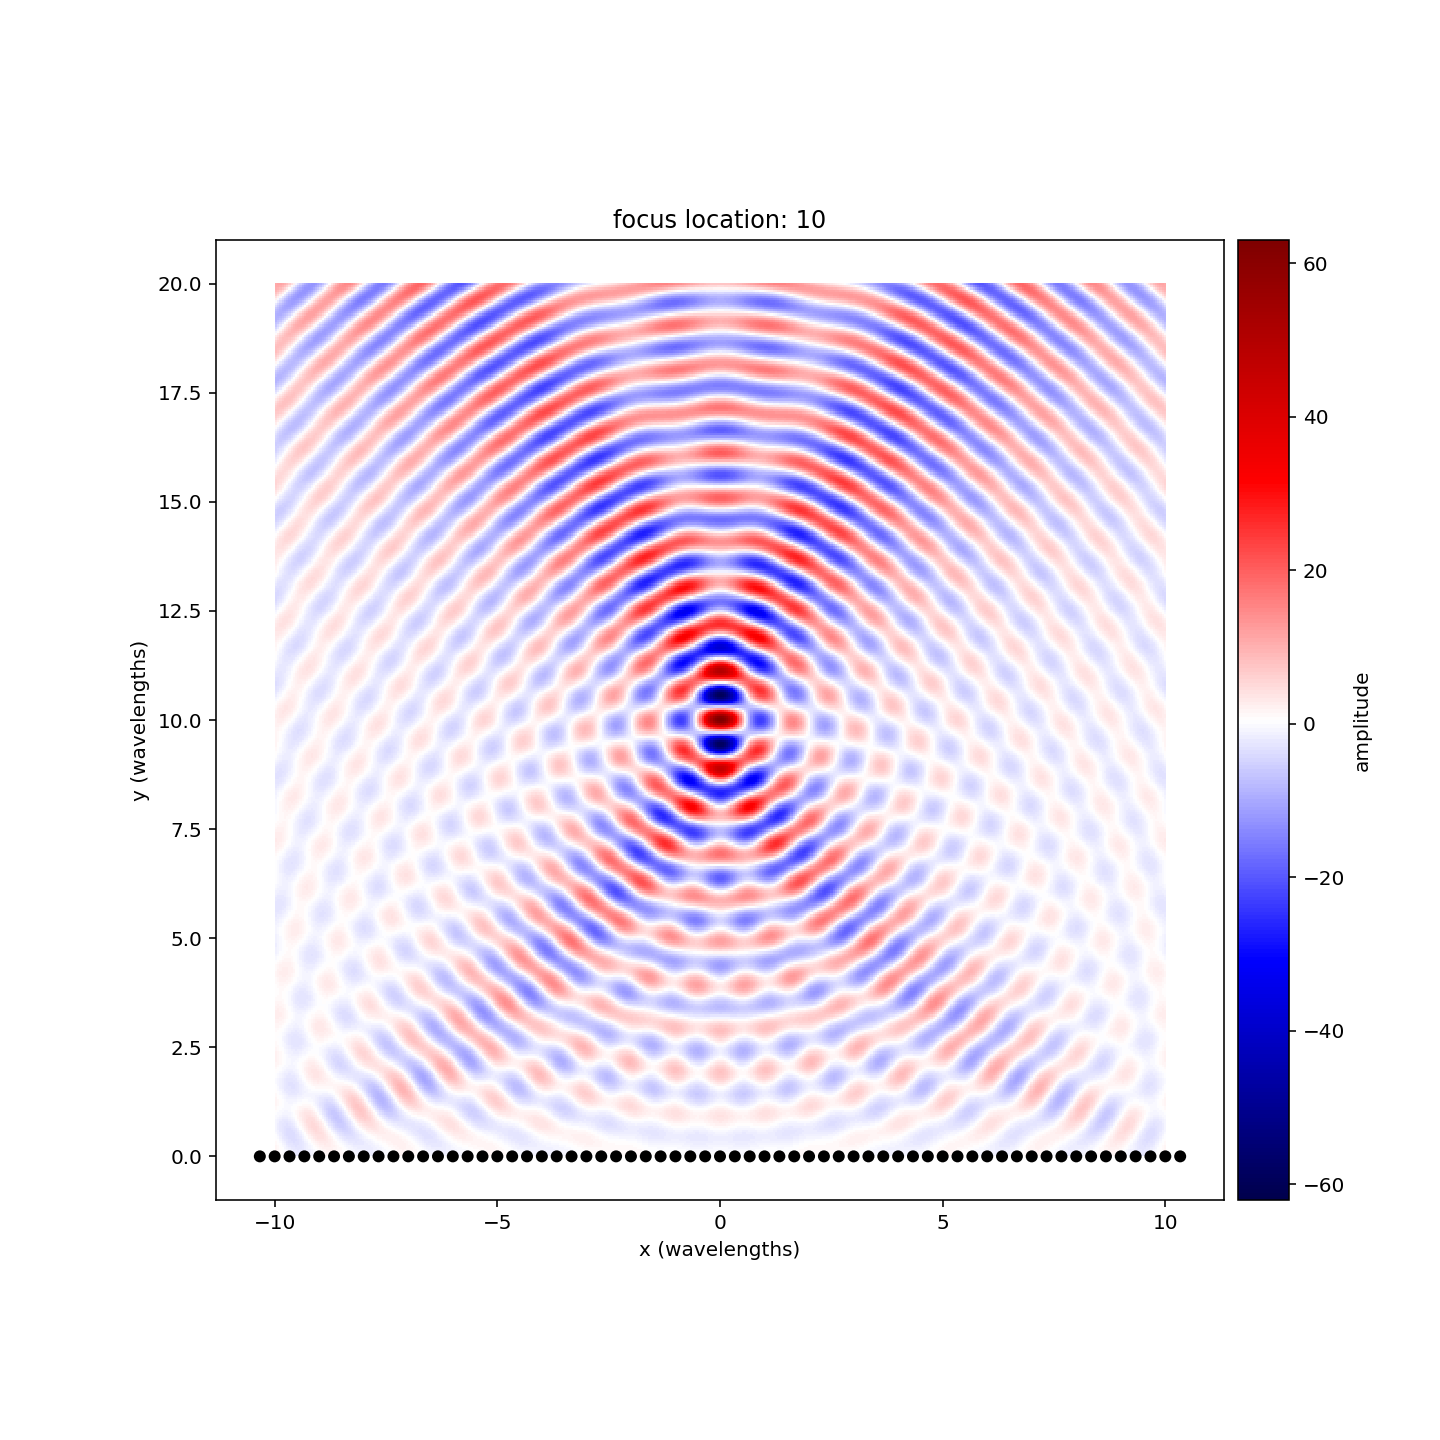
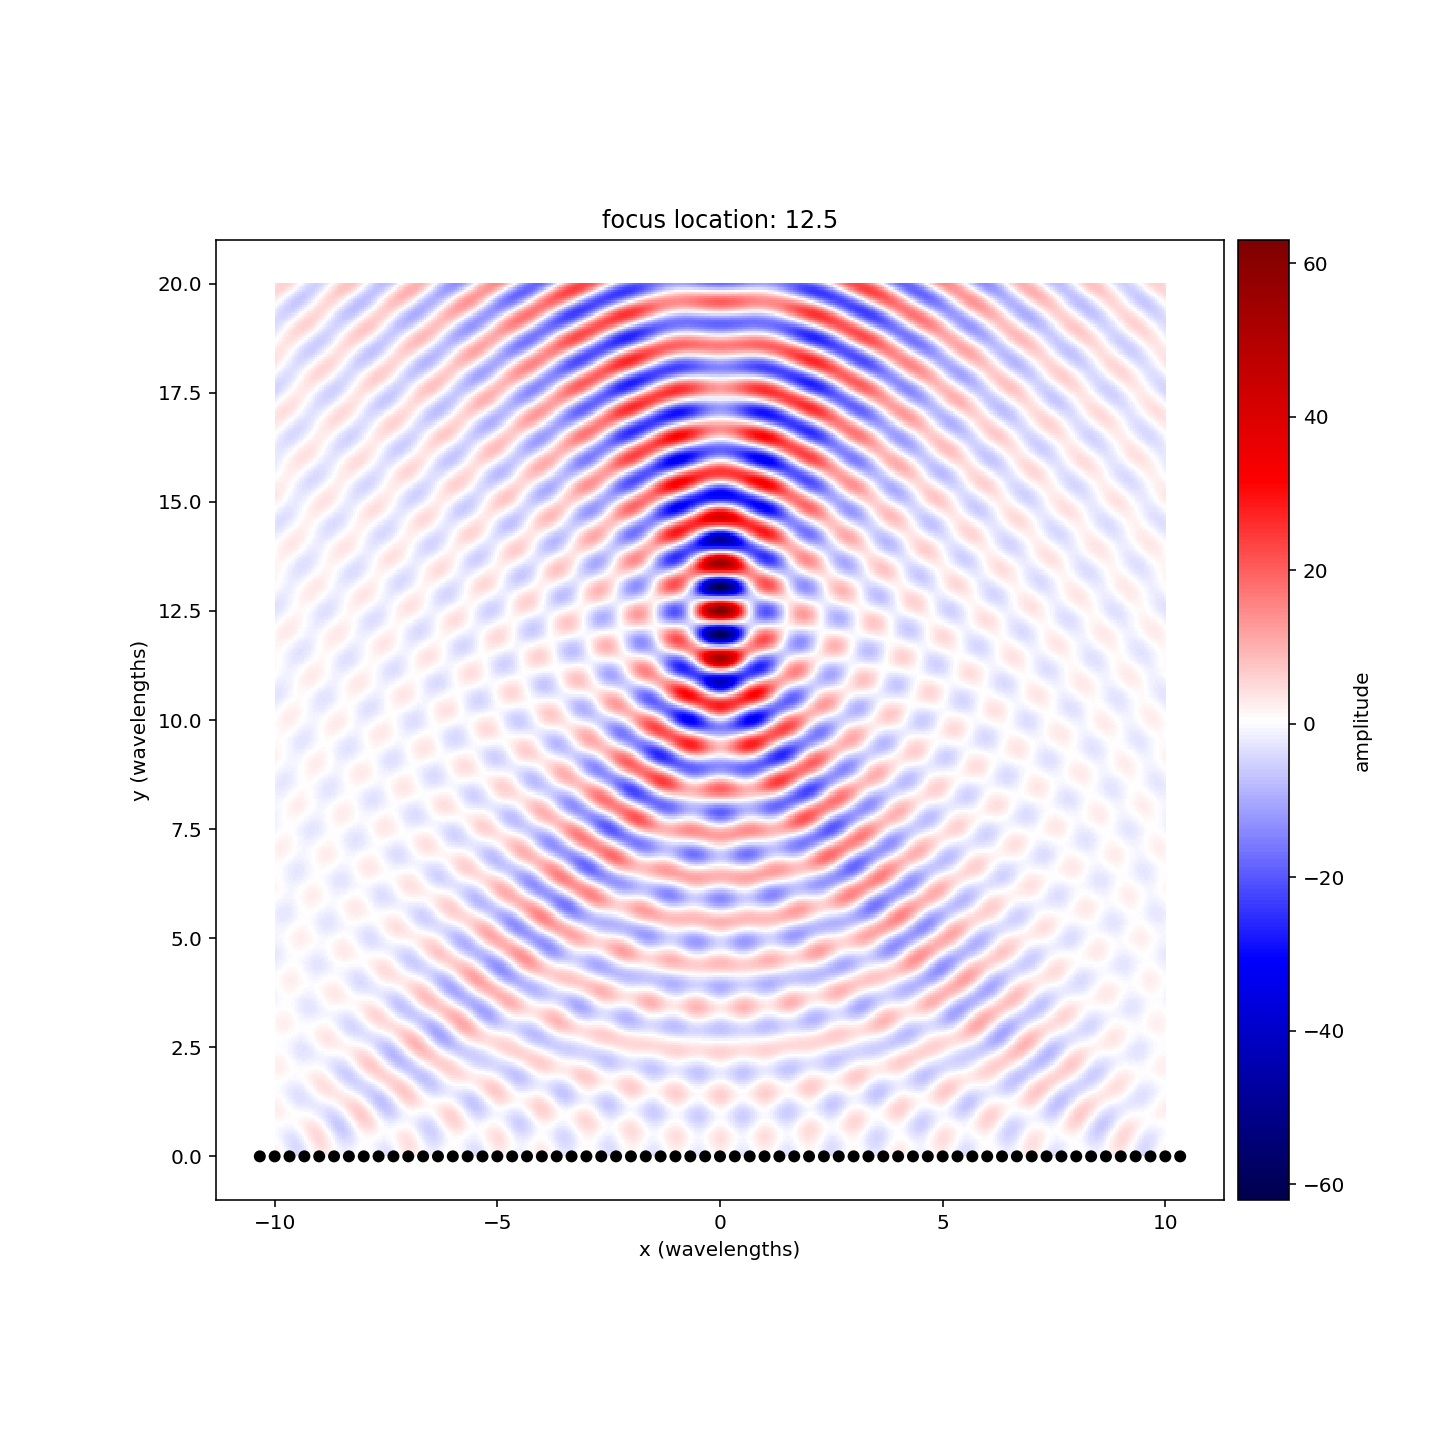
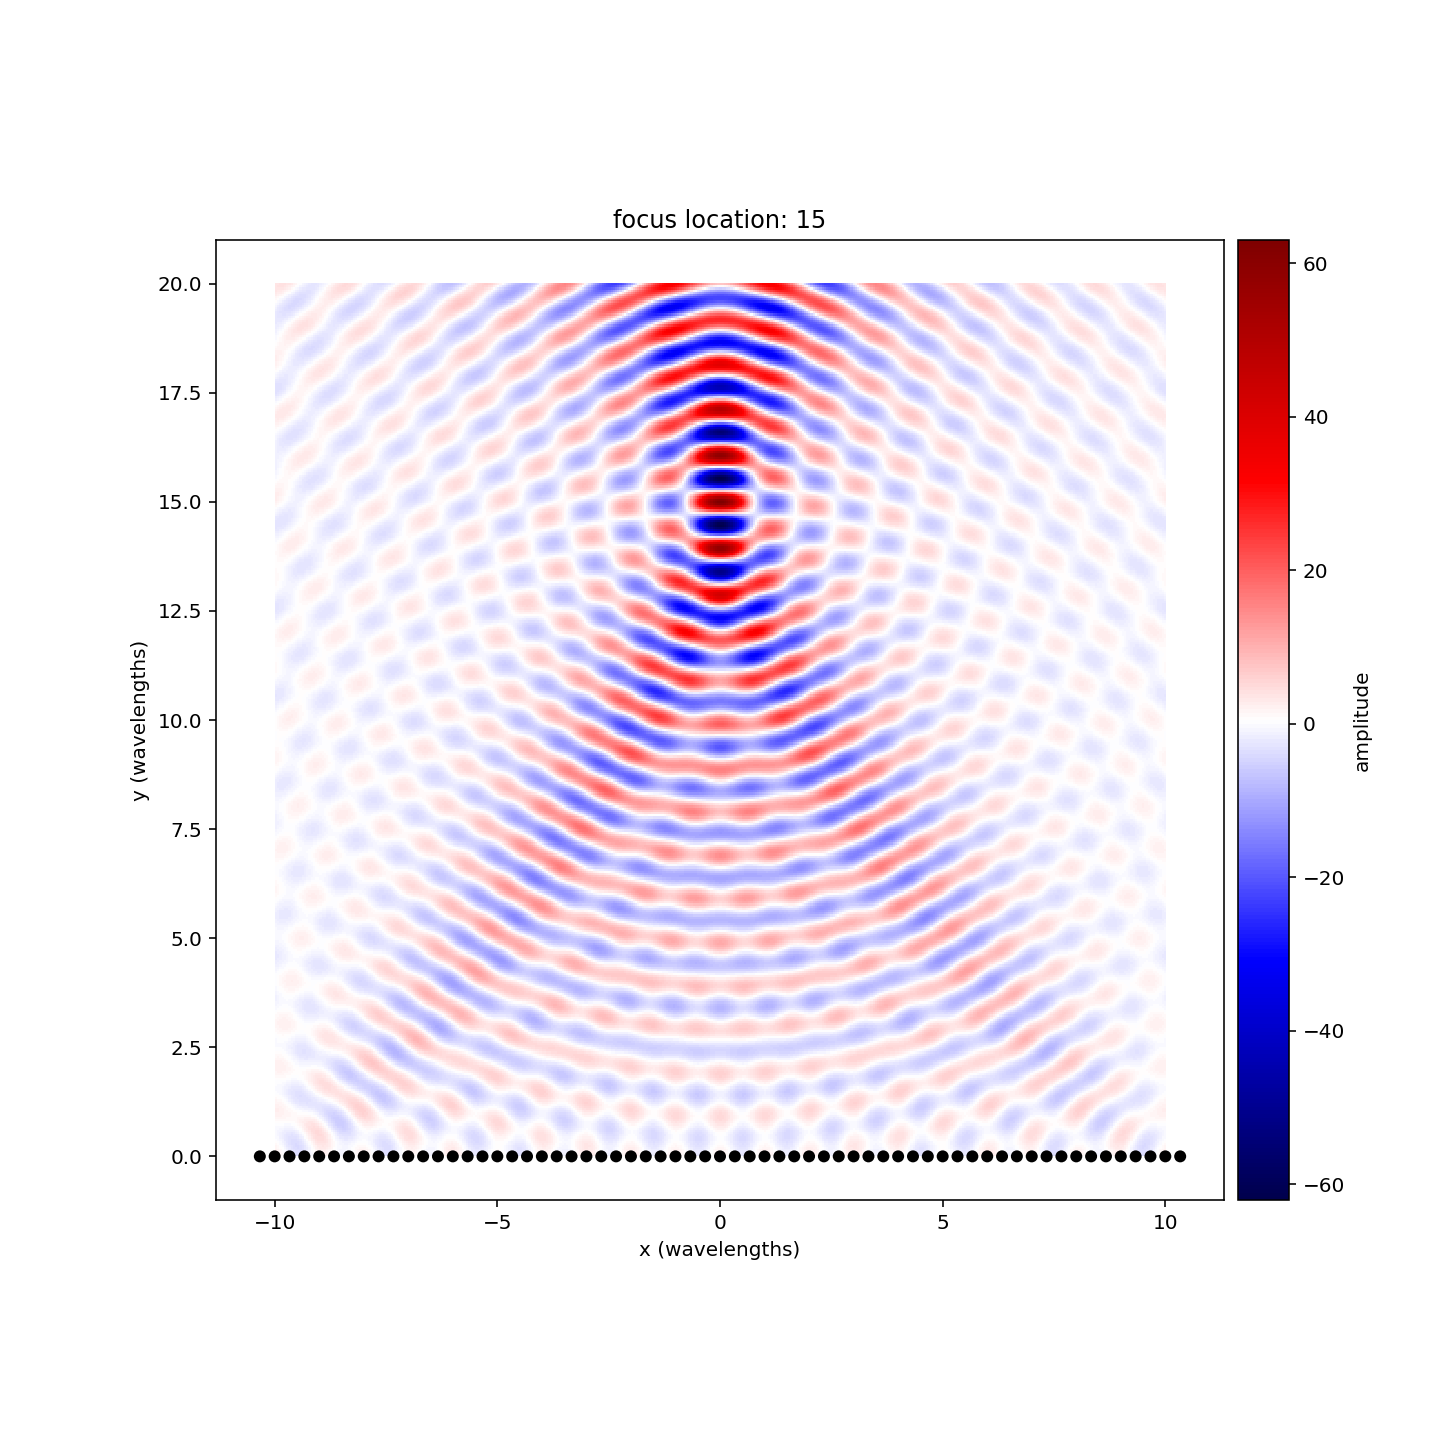
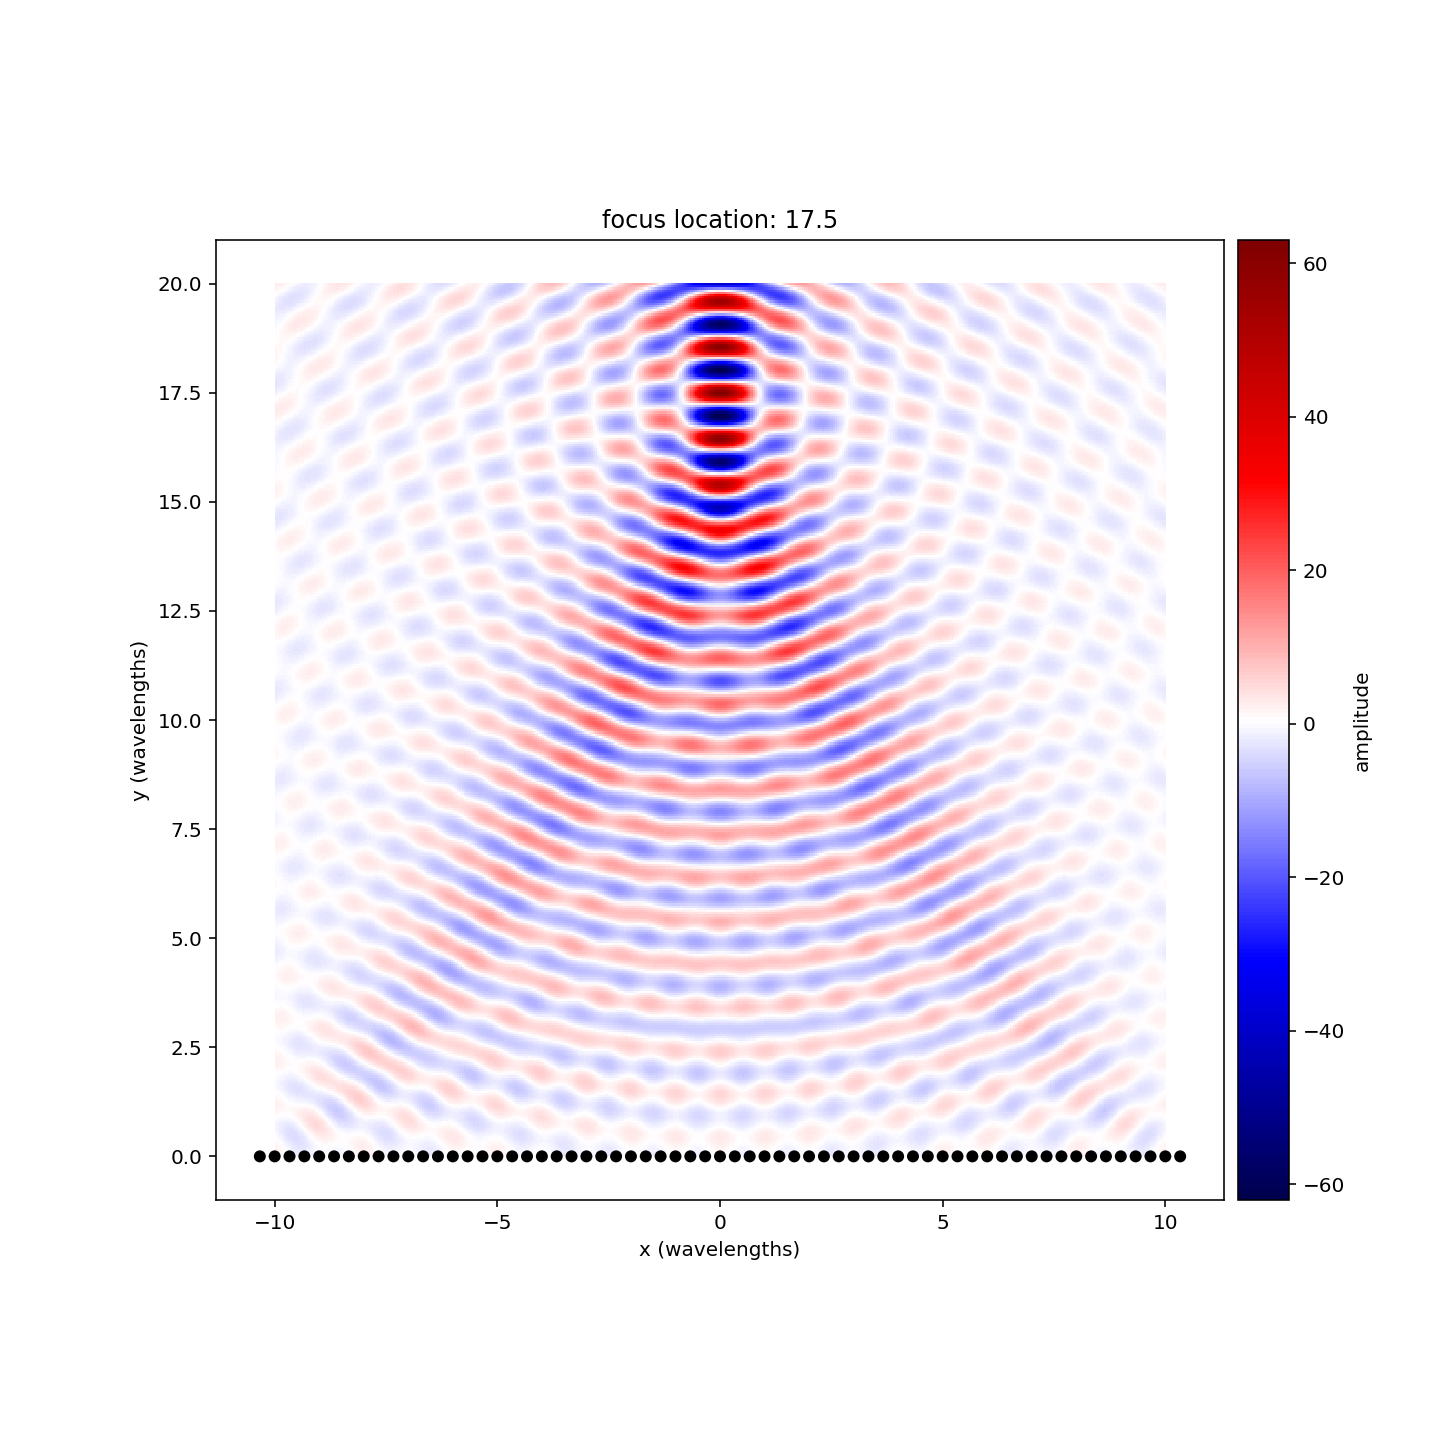
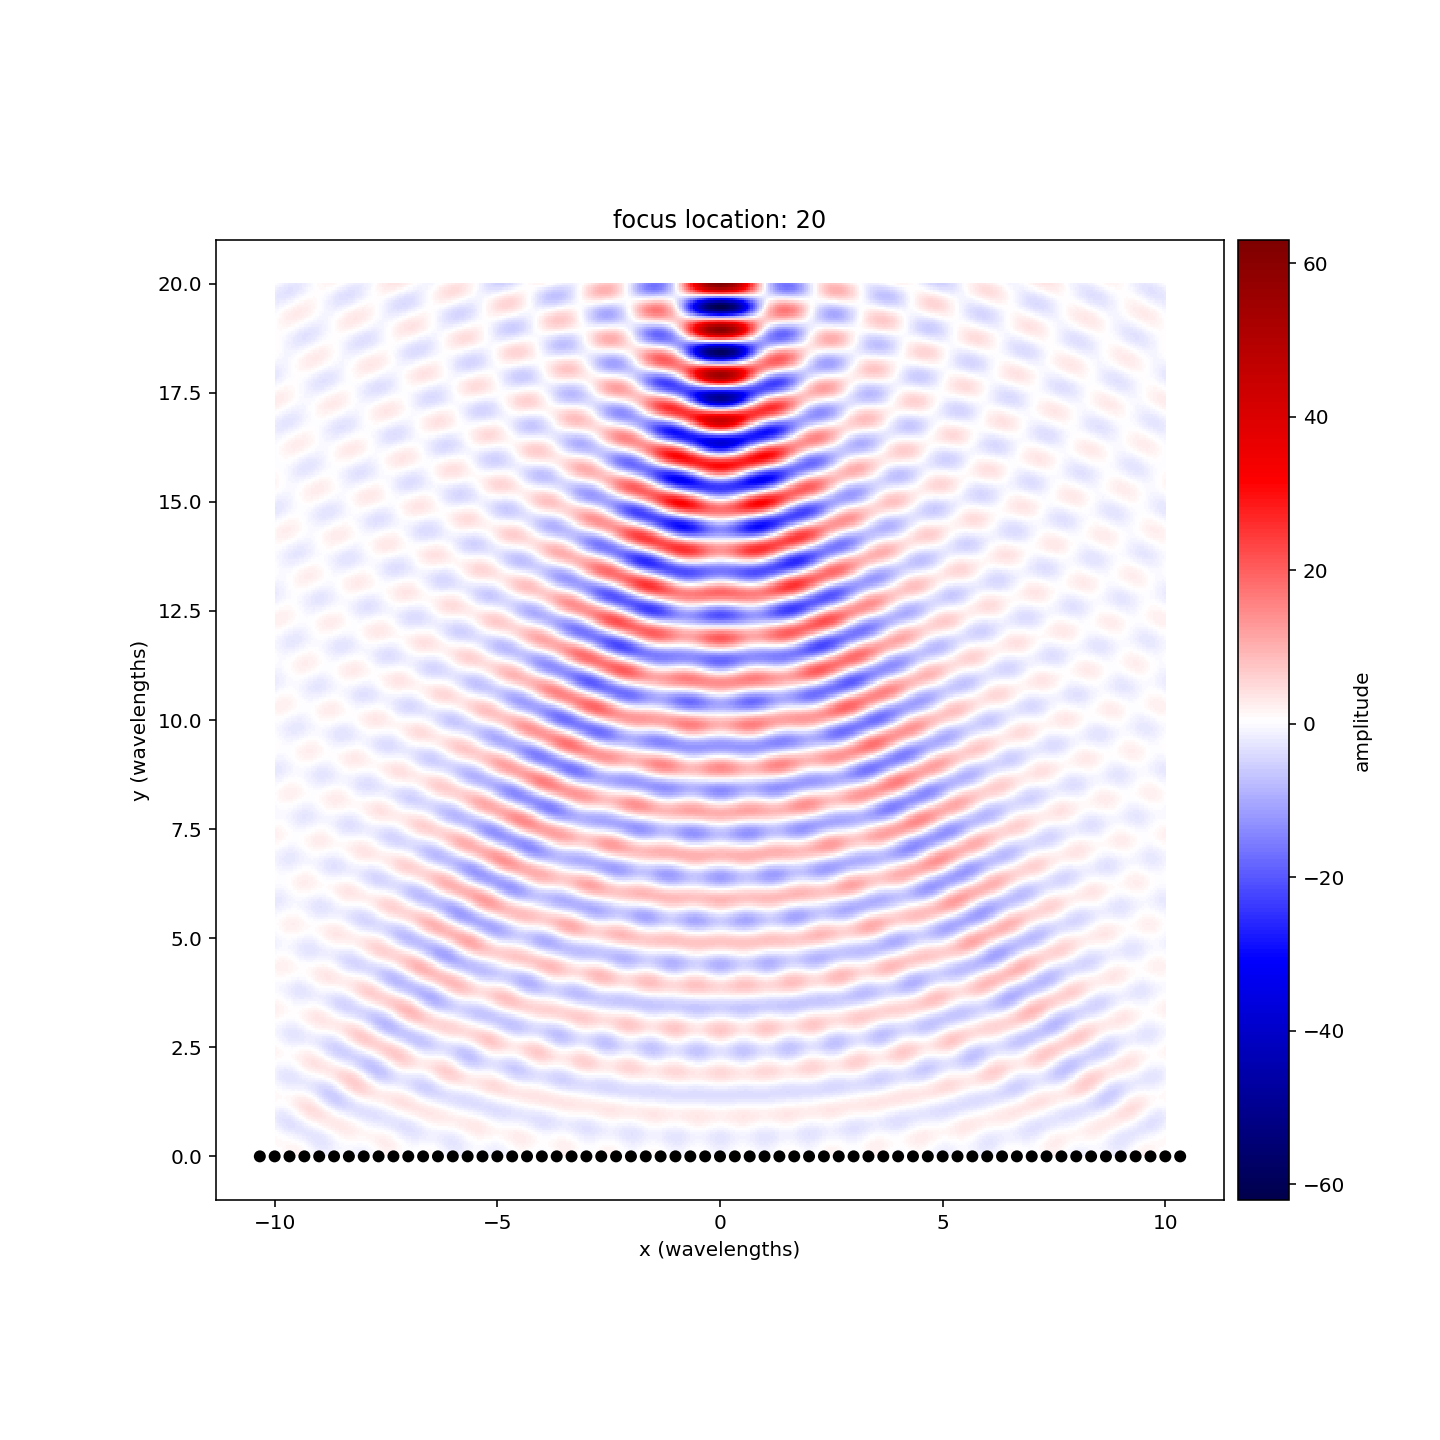
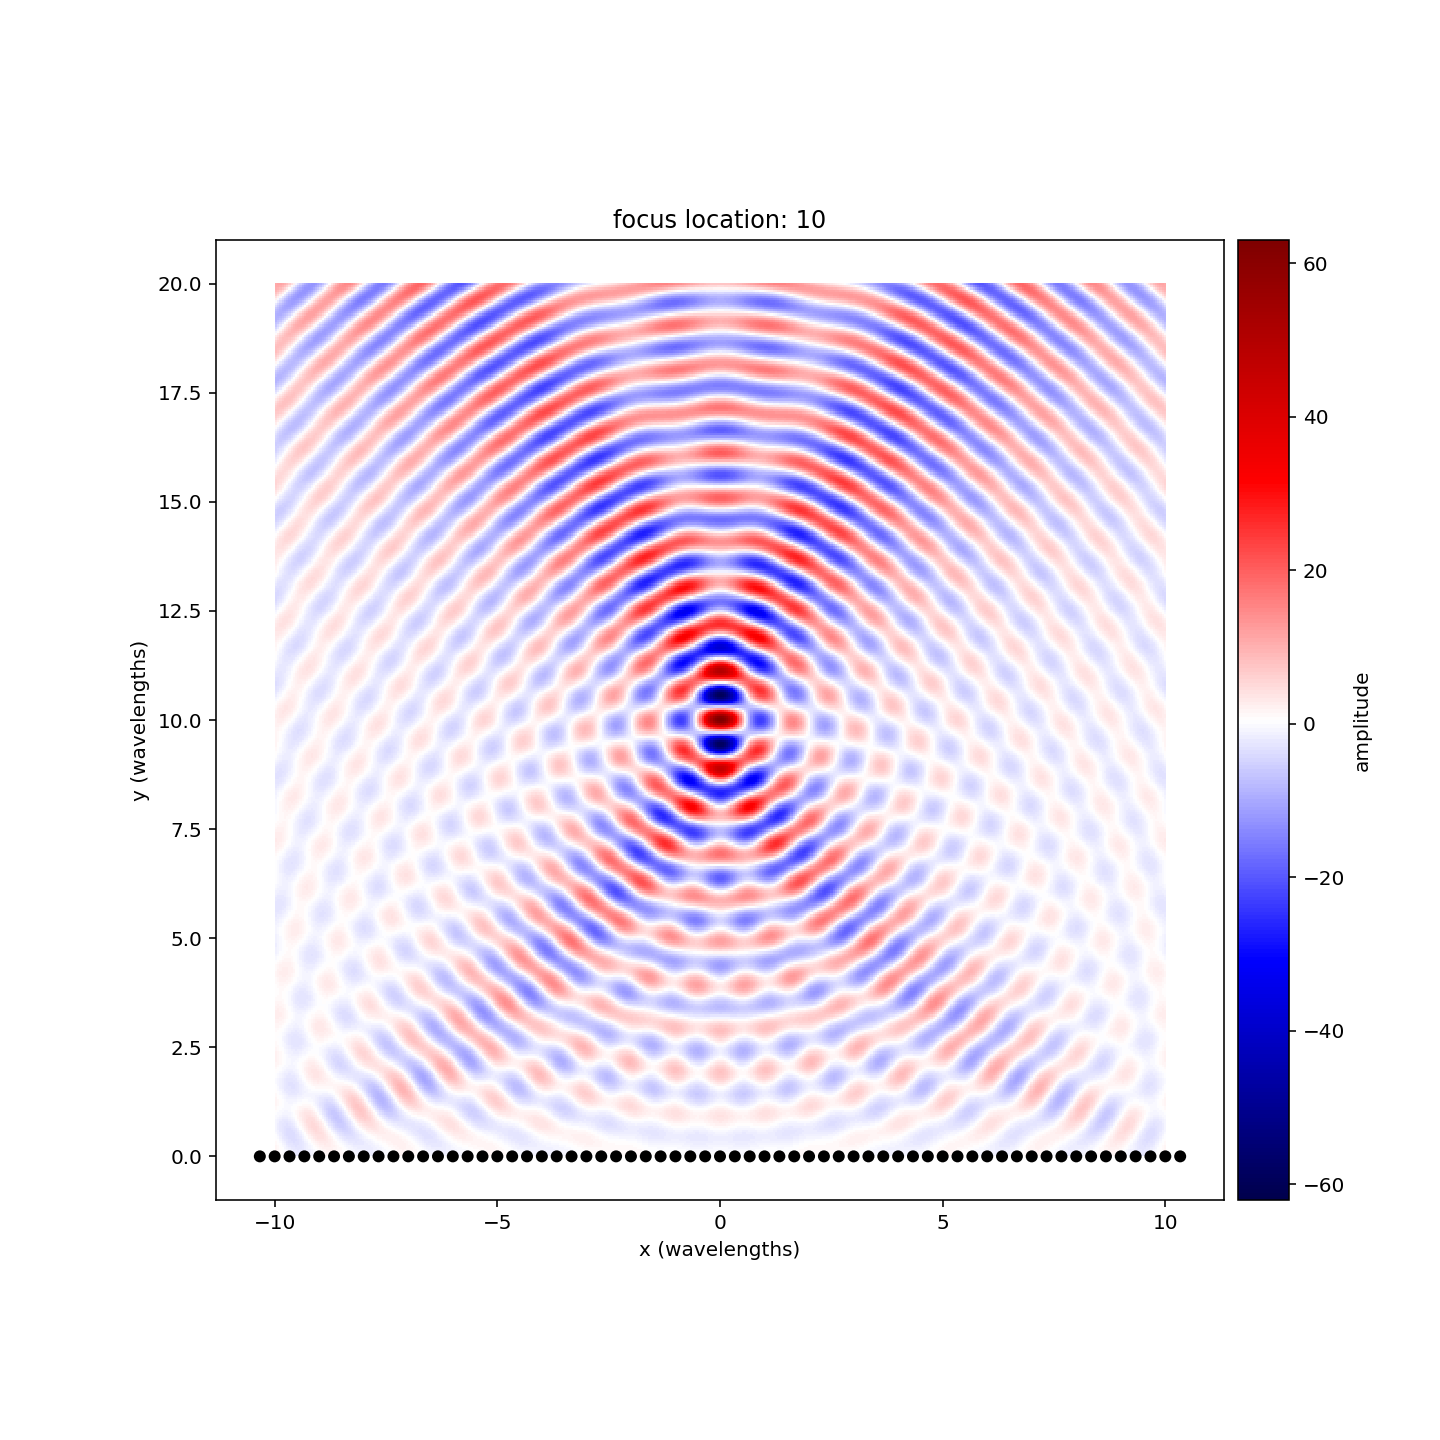

In [9]:
viz_data = {}
for y_focus in np.linspace(10, 20, num=5):
    line_source = make_symmetric_point_source(31, wavelength / 3.)
    field = compute_amplitude_from_several_points_with_focus(line_source, X, Y, k, focus_location=(0, y_focus * wavelength))
    viz_data[y_focus] = plot_field(field, line_source)
    
hv.HoloMap(viz_data, kdims='focus location')

We can also vary the angle for a given focus:

:HoloMap   [angle]
   :Overlay
      .Image.I  :Image   [x,y]   (z)
      .Points.I :Points   [x,y]
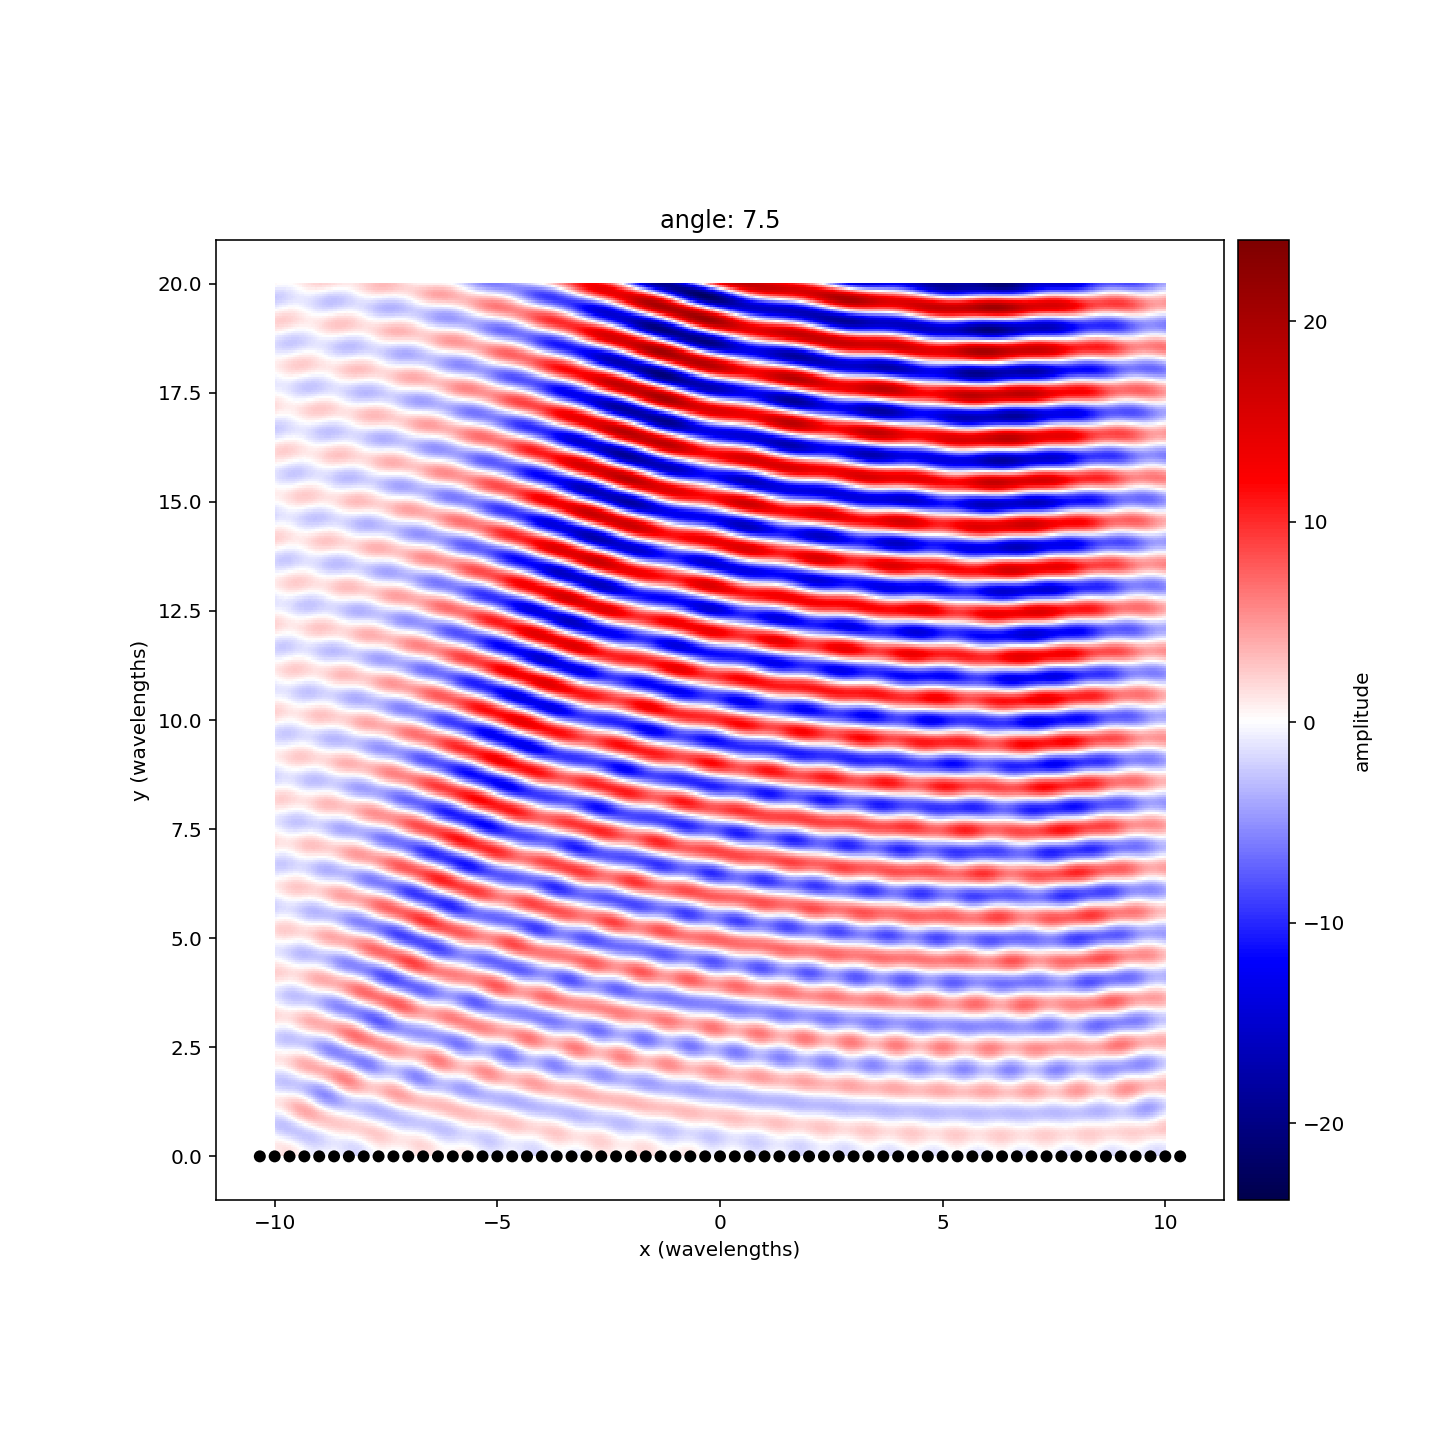
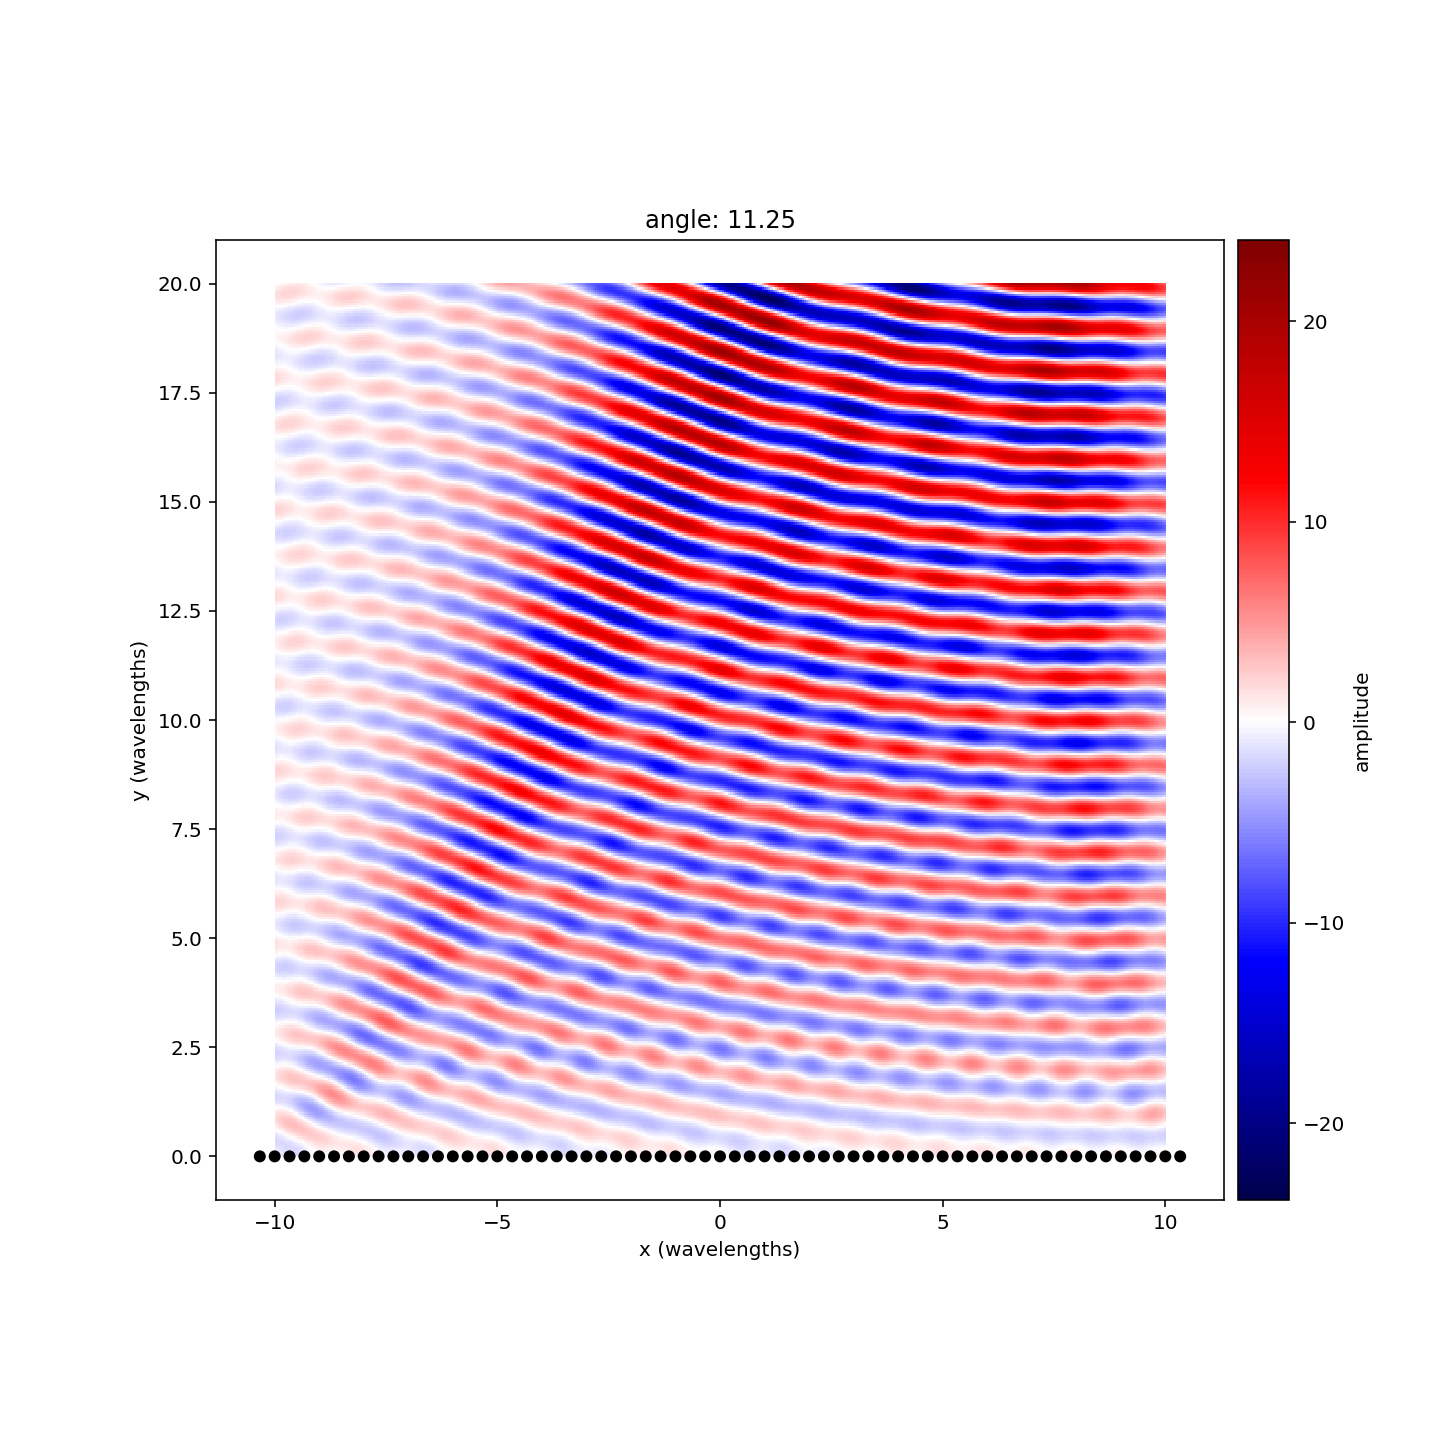
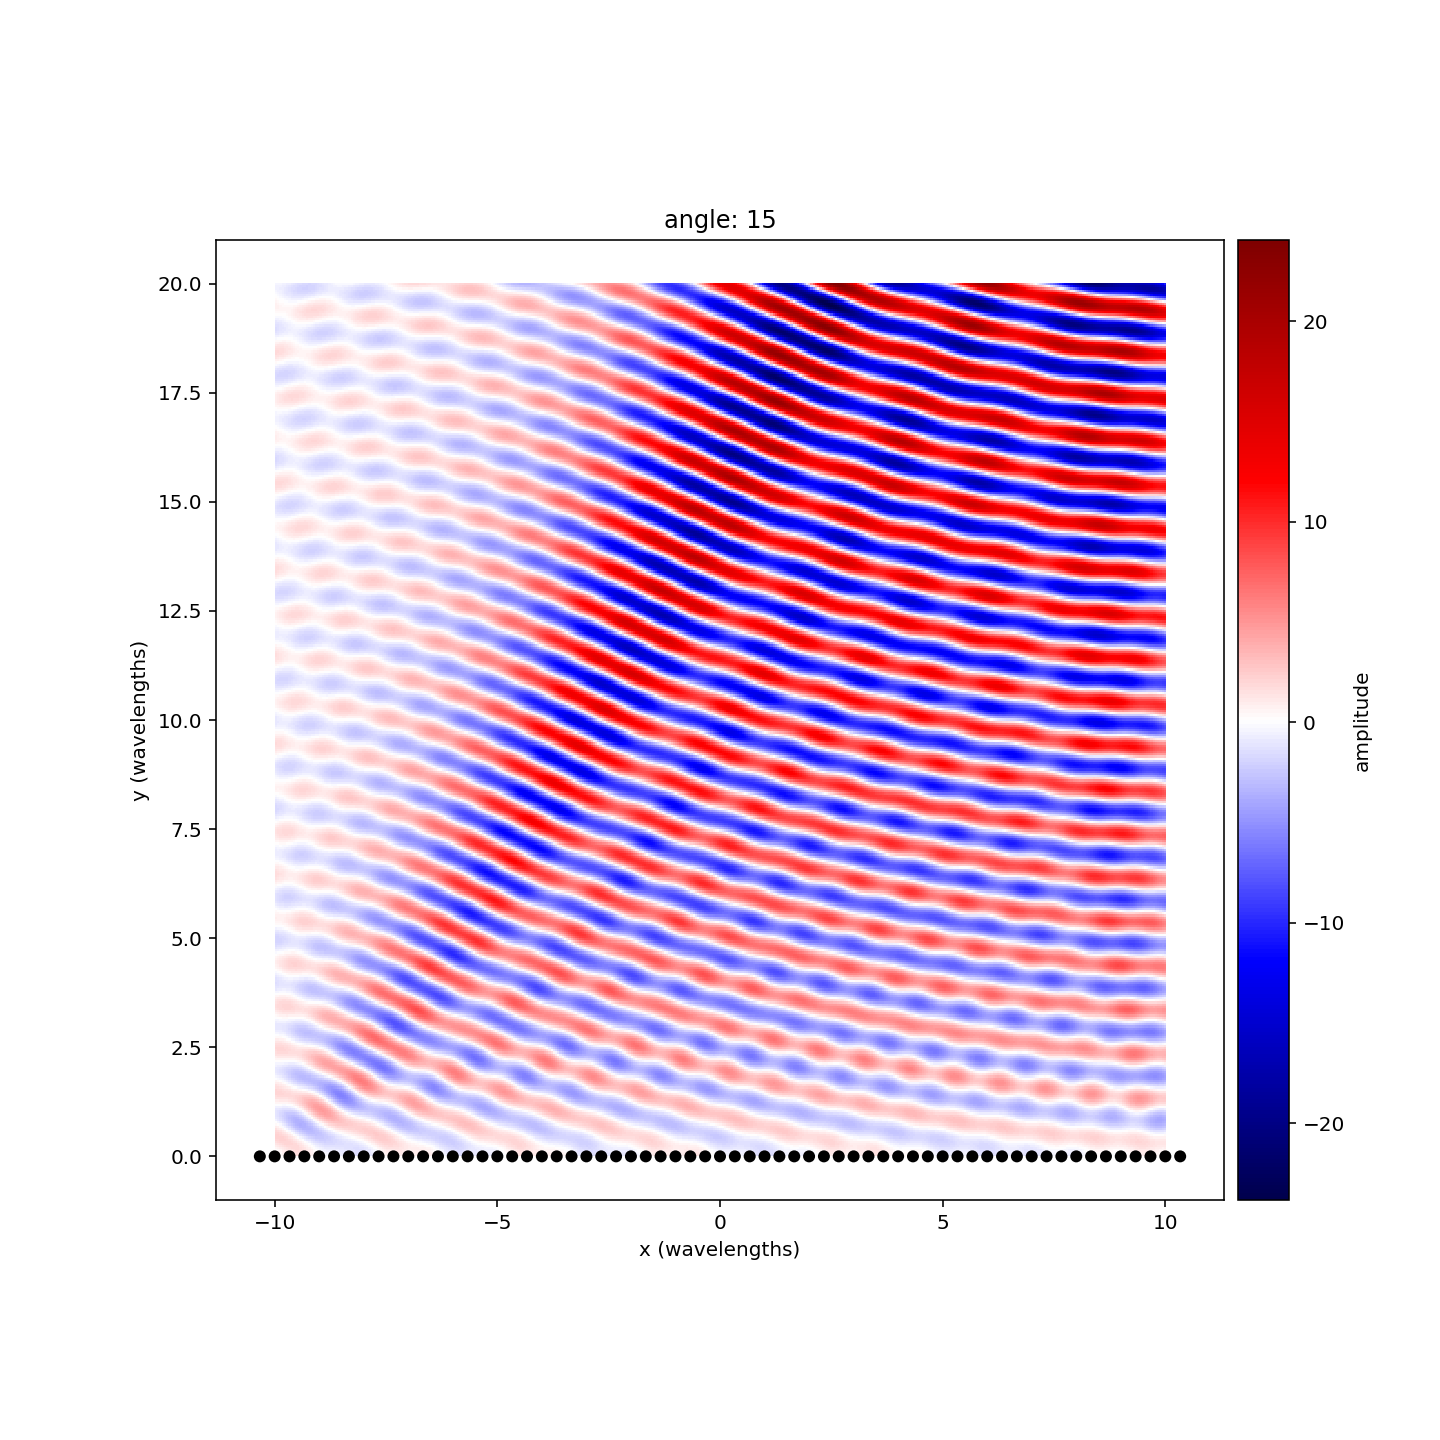
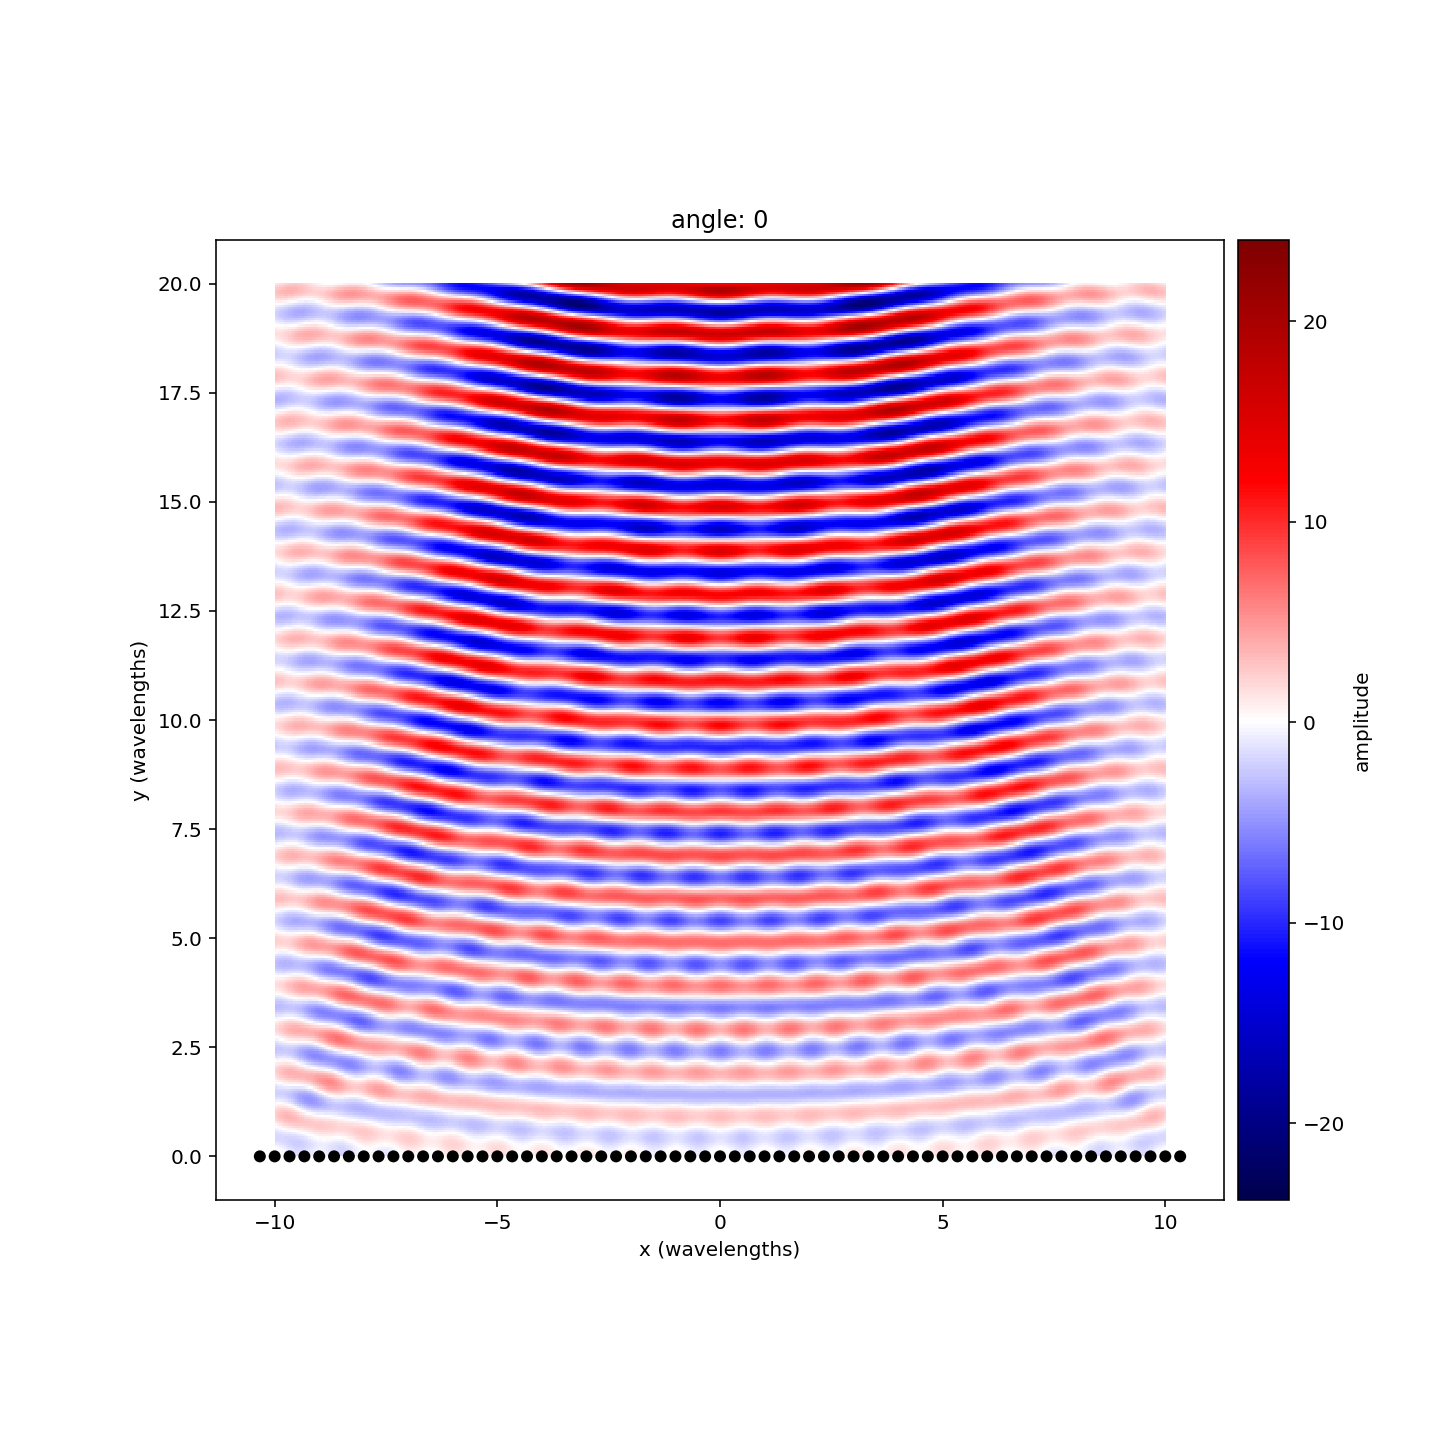

In [10]:
viz_data = {}
for angle in np.linspace(0, 15, num=5):
    focus_location = 50 * wavelength * np.array([np.cos(np.deg2rad(90 - angle)), np.sin(np.deg2rad(90 - angle))])
    line_source = make_symmetric_point_source(31, wavelength / 3.)
    field = compute_amplitude_from_several_points_with_focus(line_source, X, Y, k, focus_location)
    viz_data[angle] = plot_field(field, line_source)
    
hv.HoloMap(viz_data, kdims='angle')

# Interactive exploration with a DynamicMap

We can use one of the features of `holoviews`, a `DynamicMap` to explore the parameters interactively: 

:DynamicMap   [r,angle,n_points]
   :Overlay
      .Image.I  :Image   [x,y]   (z)
      .Points.I :Points   [x,y]
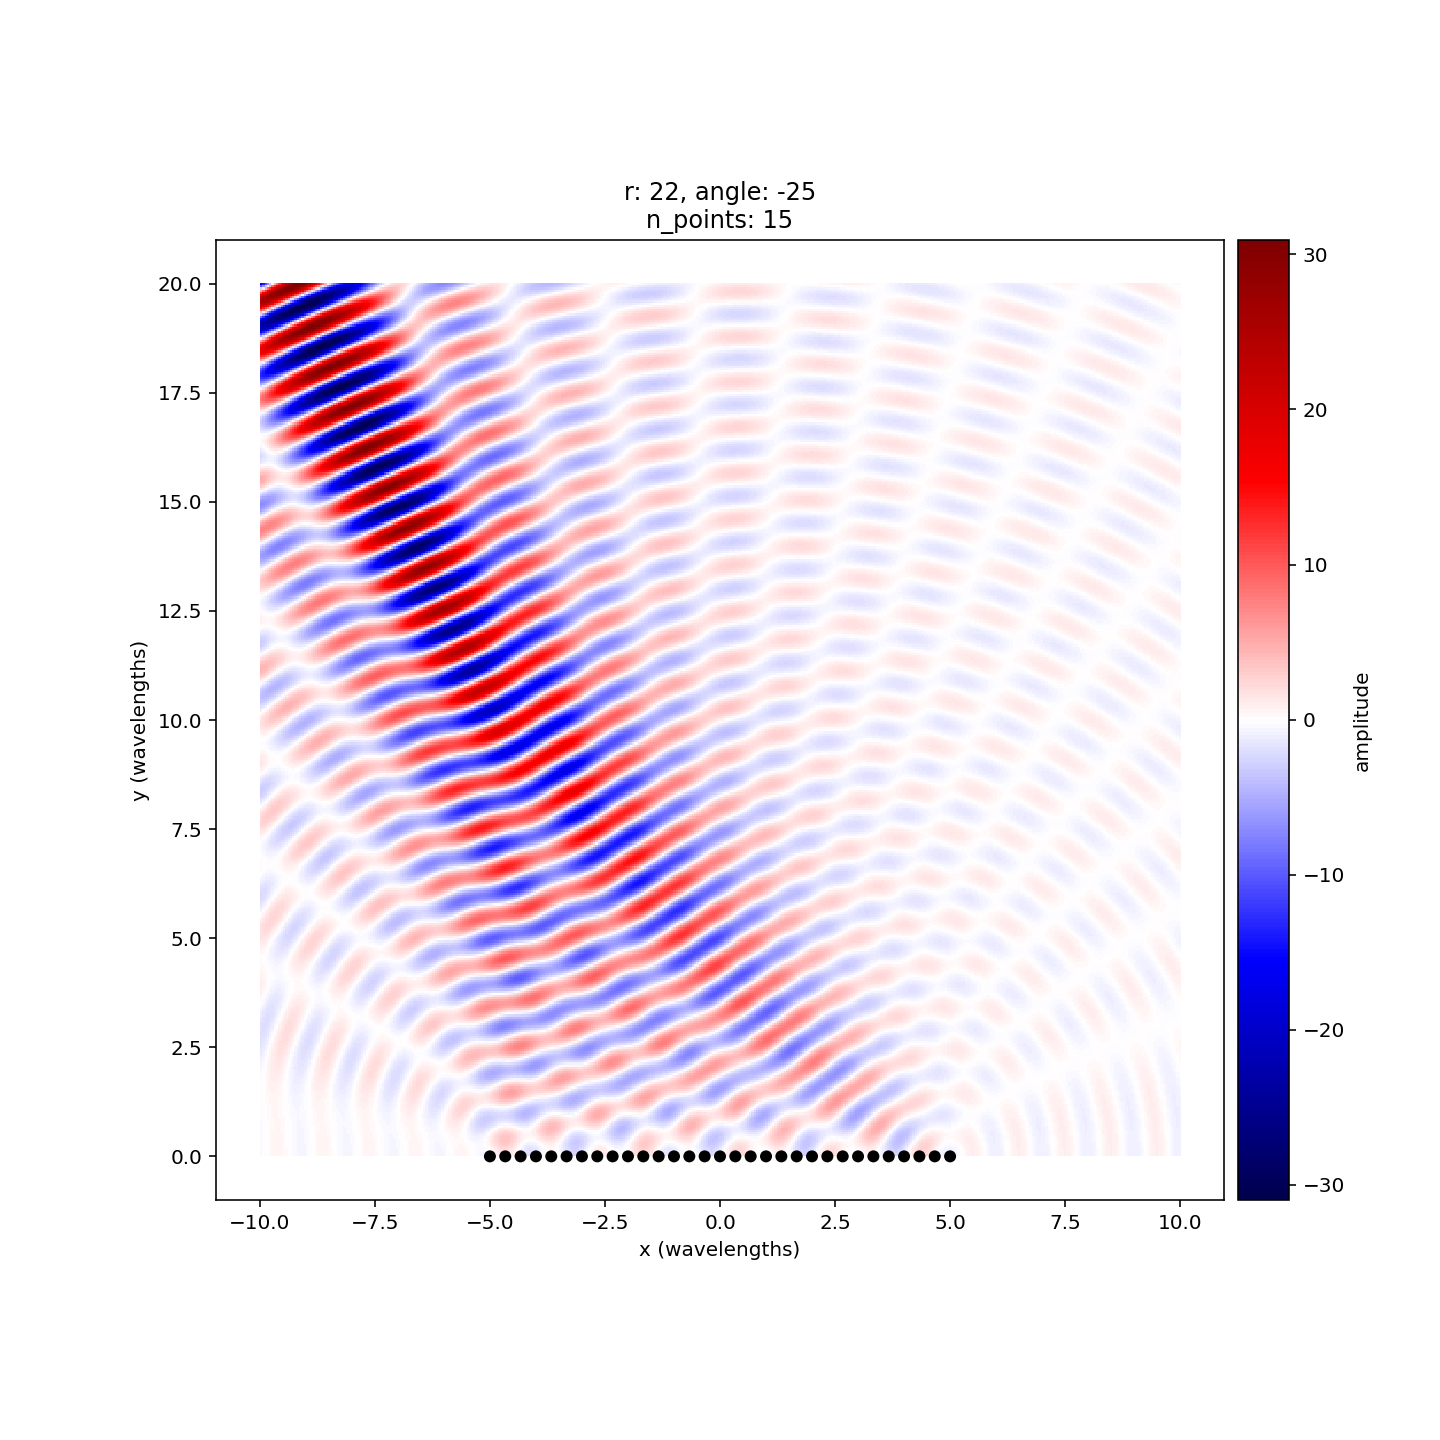

In [11]:
def plot_with_options(r, angle, n_points, normalize=False):
    focus_location = r * wavelength * np.array([np.cos(np.deg2rad(90 - angle)), np.sin(np.deg2rad(90 - angle))])
    line_source = make_symmetric_point_source(n_points, wavelength / 3.)
    field = compute_amplitude_from_several_points_with_focus(line_source, X, Y, k, focus_location)
    if normalize:
        field /= field.max()
    return plot_field(field, line_source)

hv.DynamicMap(plot_with_options, kdims=['r', 'angle', 'n_points']).redim.range(r=(5, 50), 
                                                                                angle=(-25, 25), 
                                                                                n_points=(0, 31)).redim.default(n_points=15, r=22)

# An animation like the one on Twitter

Let's build an animation using that function. We'll try to rebuild the animation from the tweet and improve it a little:

In [12]:
from tqdm import tqdm

states = [(50, 0, 0), 
                  10,
         (50, 0, 30),
                  10,
         (50, 5, 30),
                  10,
        (50, -5, 30),
                  10,
         (50, 0, 30),
                  10,
          (5, 0, 30),
                  10,
         (15, 0, 30),
                  10,
         (15, 5, 30),
                  10,
         (15, -5, 30),
                  10,
         (50, 0, 30),
                  10,
         (50, 0, 0)]

def interp(start, end, nframes, frame, isint=False):
    val =  frame / (nframes - 1) * (end - start) + start
    if isint:
        val = int(val)
    return val

hmap_data = []
frame_index = 0
for start_state, nframes, end_state in zip(states[::2], states[1::2], states[2::2]):
    for frame in tqdm(range(nframes)):
        r = interp(start_state[0], end_state[0], nframes, frame)
        angle = interp(start_state[1], end_state[1], nframes, frame)
        n_points = interp(start_state[2], end_state[2], nframes, frame, isint=True)
        hmap_data.append([frame_index, plot_with_options(r, angle, n_points)])
        frame_index += 1

# optional: save animation locally
#hv.save(hv.HoloMap(hmap_data), r'c:\Temp\holomap.gif', fps=5)

100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20200422_PhasedArrayAnimation.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20200422_PhasedArrayAnimation.ipynb).*